# Introduction to NLP: Final Project

Group members: 
- Oliver Gatland
- Angelo Di Gianvito
- Sebastien Boxho

## Project:  "Utilizing NLP Techniques for Job Search and Career Guidance in Economics  and Data Science: Intelligent Matching of CVs with Job Offers" 

This project is focused on utilizing NLP and machine learning basic techniques to create a resume matcher for job postings. After some preprocessing steps, the models utilized include TF-IDF, LDA, Logistic Regression, Random Forest Classifiers and Cosine Similarity. The project is structured as follows:

1. [Data Analysis](#data-analysis)
    - [EDA of Jobs Dataset](#eda-of-jobs-dataset)
    - [Proeprocessing Job Descriptions](#preprocessing-descriptions)
    - [EDA of Resume Dataset](#eda-of-resume-dataset)
    - [Proeprocessing Resumes](#preprocessing-resumes)
3. [Skills extraction](#skills-extraction)
    - [Training NER Model](#training-ner-model)
    - [Applying model](#applying-model)
    - [Document Term Matrix](#document-term-matrix)

4. [LDA analysis](#lda-analysis)
    - [Results](#results)
    - [Coherence of Topics](#coherence-of-topics)
5. [Model comparison - Job offers](#model-comparison-for-job-offers)
    - [Preprocessing](#preprocessing)
    - [Cosine Similarity (mode)](#model:-cosine-similarity-(mode))
    - [Cosine Similarity (average)](#model:-cosine-similarity-(average))
    - [Logistic Regression](#model:-logistic-regression)
    - [Random Forest](#model:-random-forest-classifier)

5. [Model comparison - Resume to Job Matcher](##model-comparison---resume-to-job-matcher)
    - [Cosine Similarity (mode)](#model:-cosine-similarity-(mode-match))
    - [Cosine Similarity (average)](#model:-cosine-similarity-(average-match))
    - [Logistic Regression](#model:-logistic-regression-match)
    - [Random Forest](#model:-random-forest-classifier-match)
6. [Required Skills per job](#required-skills-per-job) 
    - [Most relevant skills](#finding-most-relevant-skills)

In [217]:
import os
import re
import sys
import nltk
import pickle
import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt 
from collections import Counter
from IPython.display import display, HTML
from concurrent.futures import ThreadPoolExecutor

# ML Functions
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# NLP functions
from datasets import load_dataset
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('stopwords')
from wordcloud import WordCloud
import docx2txt
import requests
import subprocess
from gensim.models.coherencemodel import CoherenceModel
from tabulate import tabulate
# from textblob import TextBlob
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix
from langdetect import detect
from nltk.corpus import stopwords
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
#!python -m spacy download en_core_web_sm
import spacy
from spacy.tokens import DocBin
from tqdm import tqdm
sp = spacy.load('en_core_web_sm')

from src.preprocessing import *

lmtzr = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

import warnings
# Ignore SettingWithCopyWarning
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, module="pandas")
warnings.filterwarnings("ignore", category=FutureWarning, module="pandas")

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /Users/user/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Data Analysis

To improve the readability of this Notebook some of the preprocessing functions used in the coming cells are imported from the preprocessing.py file.

### Importing data

In [218]:
path_jobs_indeed = './data/job_postings/indeed_scrapped_jobs.csv'
path_cv = './data/cv/Resume Screening.csv'
data_resume = pd.read_csv(path_cv)
df_resume = pd.DataFrame(data_resume)
data_jobs = pd.read_csv(path_jobs_indeed)
df_jobs = pd.DataFrame(data_jobs) 
print("Shape of resume: ",df_resume.shape)
print("Shape of jobs: ",df_jobs.shape)

Shape of resume:  (962, 2)
Shape of jobs:  (2160, 6)


In [219]:
df_jobs.head()

,Job title,Company,Description,Job_Title_Searched,Location_Searched,Location
0,Data Analyst,UCLA,About the California Policy Lab\nThe Californi...,Data Science,Los Angeles,"Los Angeles, CA"
1,Research Data Scientist,CEDARS-SINAI,Job Description\nThe Research Data Scientist p...,Data Science,Los Angeles,"Los Angeles, CA"
2,Data Scientist,NaN,Expatiate Communications is a boutique managem...,Data Science,Los Angeles,"Pasadena, CA"
3,DATA SCIENTIST,Los Angeles County Department of Human Resources,EXAM NUMBER:\nPH1763B\n\nTYPE OF RECRUITMENT:\...,Data Science,Los Angeles,"Los Angeles County, CA"
4,Predictive Data Analyst - CalAIM,Heluna Health,Salary: $42.59 - $57.40 Per Hour\nSUMMARY\nCom...,Data Science,Los Angeles,"Los Angeles, CA 90014"


### EDA of Jobs Dataset

Number of different job titles: 12


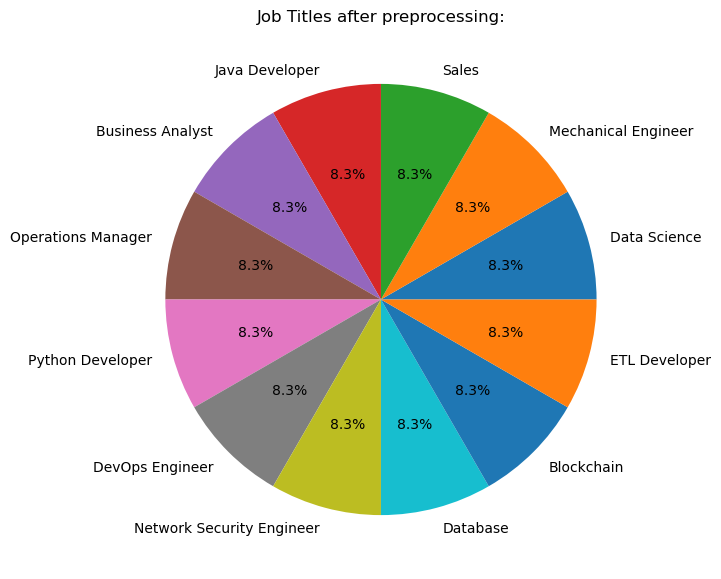

In [220]:
print(f'Number of different job titles: {df_jobs["Job_Title_Searched"].nunique()}')
job_title_freq = df_jobs['Job_Title_Searched'].value_counts().reset_index()
job_title_freq.columns = ['Job_Title_Searched', 'frequency']
# Plot pie chart of the 7 job titles
plt.figure(figsize=(10, 7))
plt.pie(job_title_freq['frequency'], labels=job_title_freq['Job_Title_Searched'], autopct='%1.1f%%')
plt.title('Job Titles after preprocessing:')
plt.show()

The graph shows that the data on job posting is perfectly balanced between the classes. There are around 8.3% of the total postings per job title.

### Preprocessing Descriptions

For now we will just apply lowercasing and remove the special characters (also numbers), there will be further preprocessing in following steps.

In [221]:
print("Shape of resume: ",df_resume.shape)
print("Shape of jobs (before): ",df_jobs.shape)
# Only keep the relevant columns
df_jobs = df_jobs[['Job_Title_Searched', 'Description']]

#Drop the rows with missing values
df_jobs = df_jobs.dropna()

# Preprocess the categorical data
# modulation: 0 -> remove stop words, 1 -> remove stop words and stem words, 2 -> remove stop words and lemmatize words
df_jobs['cleaned_description'] = df_jobs['Description'].apply(remove_special_characters)
df_jobs["cleaned_description"] = df_jobs["cleaned_description"].apply(tokenize, modulation=0) 
df_resume['cleaned_resume'] = df_resume['Resume'].apply(remove_special_characters)
df_resume["cleaned_resume"] = df_resume["cleaned_resume"].apply(tokenize, modulation=0)

print("Shape of jobs (after): ",df_jobs.shape)

Shape of resume:  (962, 2)
Shape of jobs (before):  (2160, 6)
Shape of jobs (after):  (2149, 3)


In [222]:
descr_end = ['work life balance', 'we are proud' ,'our mission' ,'proud to be' , 'we truly believe' , 'what you ll benefit','for more information', 'for more info', 
                    'share this', 'share this job', 'discover our', 'follow us', 'we welcome applicants', 'if you think you have', 'we believe', 
                    'we do not discriminate', 'discriminate', 'equal opportunity', 'additional information', 'equal employment opportunity', 
                    'find out more about','find out more', 'build a better future', 'want to know more', 'know more', 'who we are', 'what do we offer', 
                    'what we offer','for enquiry', 'about us', 'affirmative action', 'what you ll find', 'data protection policy', 'personal data protection policy', 
                    'personal data protection', 'if you think you', 'we offer you', 'we invite you','what you will have', 'what you will get', 'flexible hours',
                    'multicultural work environment', 'race', 'color', 'religion', 'sex', 'disability', 'sexual orientation', 'to submit your application', 
                    'benefits', 'we are looking forward', 'apply now', 'insurance', 'where you will work', 'where it will be', 'if you are']

In [223]:
# Excluding words pattern
exclude_pattern = f"({'|'.join(map(re.escape, descr_end))})(.*?$)"

# Applying the regex pattern to exclude content after specified words
def exclude_content(description):
    if pd.notna(description):  # Check for non-NaN values
        return re.sub(exclude_pattern, '', description, flags=re.IGNORECASE | re.DOTALL)
    else:
        return np.nan

# Applying the extraction function to the DataFrame
df_jobs = df_jobs.copy()

# Excluding words
exclude_pattern = f"({'|'.join(map(re.escape, descr_end))})(.*?$)"

# Applying the regex pattern to exclude content after specified words
def exclude_content(description):
    if pd.notna(description):  # Check for non-NaN values
        return re.sub(exclude_pattern, '', description, flags=re.IGNORECASE | re.DOTALL)
    else:
        return np.nan

df_jobs['cleaned_extracted_description'] = df_jobs['cleaned_description'].apply(exclude_content)

# Optionally, you can replace empty strings with NaN in the processed column
df_jobs['cleaned_extracted_description'].replace('', np.nan, inplace=True)
print(df_jobs.shape)

# Checking unatched descriptions to improve the matcher rules
df_missing = df_jobs[df_jobs['cleaned_extracted_description'].isna()]
df_extracted = df_jobs.dropna()
print(f'Percentage of unmatched descriptions: {round((df_missing.shape[0])/(df_jobs.shape[0])*100, 2)}%')

(2149, 4)
Percentage of unmatched descriptions: 0.47%


### Analyzing description length

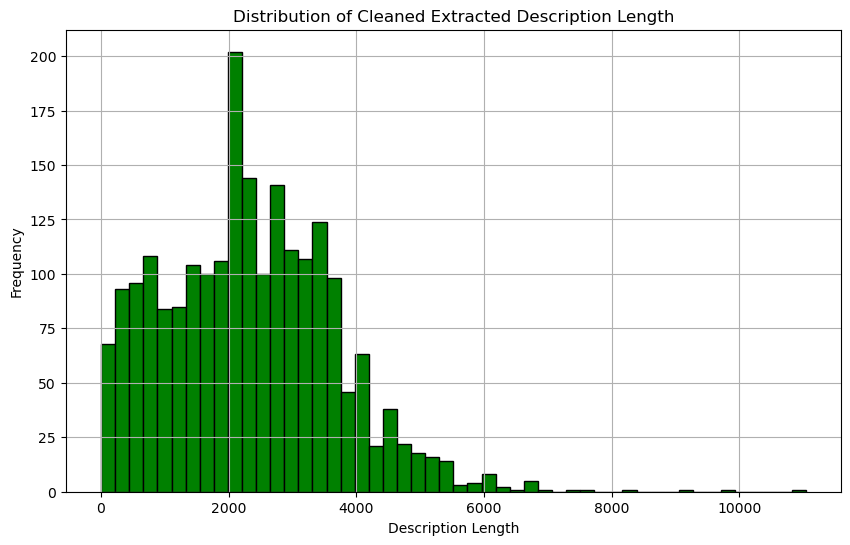

In [224]:
import matplotlib.pyplot as plt

# Calculate the length of each cleaned extracted description
df_jobs['description_length'] = df_jobs['cleaned_extracted_description'].str.len()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(df_jobs['description_length'], bins=50, color='green', edgecolor='black')
plt.title('Distribution of Cleaned Extracted Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


We can see that no description is shorter than 50 words, but that there are several outliers on the other hand that get longer than 10000 words even. This will make the analysis biased, so we will use windsorizing techniques to cut the descriptions that are too long. 

The treshold is set at 1.5 standard deviations from the mean as it outputs resonable lenghts for the descriptions. 

Descriptions dimensions: 306 to 4348 words


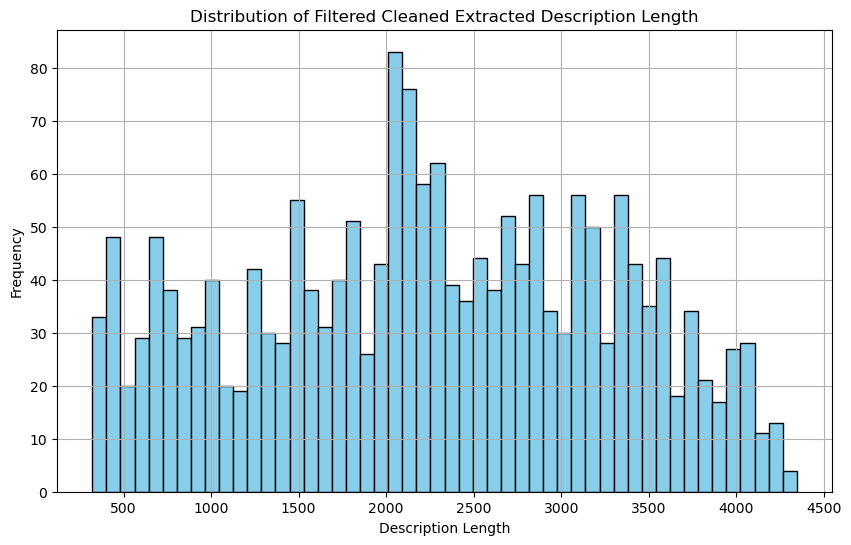

Mean length: 2327.27863487611
Standard deviation: 1347.3833081947682
Lower bound: 306.20367258395777
Upper bound: 4348.353597168262


In [225]:
# Calculate mean and standard deviation of description lengths
mean_length = df_jobs['description_length'].mean()
std_dev = df_jobs['description_length'].std()

# Define the lower and upper bounds for acceptable description lengths
lower_bound = mean_length - 1.5 * std_dev
upper_bound = mean_length + 1.5 * std_dev

print('Descriptions dimensions:', round(lower_bound), 'to', round(upper_bound), 'words')

# Filter out descriptions that are too short or too long
df_filtered = df_jobs[(df_jobs['description_length'] >= lower_bound) & (df_jobs['description_length'] <= upper_bound)]

# Plotting the histogram of filtered descriptions
plt.figure(figsize=(10, 6))
plt.hist(df_filtered['description_length'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Filtered Cleaned Extracted Description Length')
plt.xlabel('Description Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

print(f"Mean length: {mean_length}")
print(f"Standard deviation: {std_dev}")
print(f"Lower bound: {lower_bound}")
print(f"Upper bound: {upper_bound}")


The distribution shows now a much more even distribution now of the available description length that is now closer to normal. Obviously some descriptions will be lost so the available data will be less.

In [226]:
print(f'Cut descriptions: {df_jobs.shape[0]-df_filtered.shape[0]}')

Cut descriptions: 274


We will now substitute the original dataframe with the new filtered dataframe.

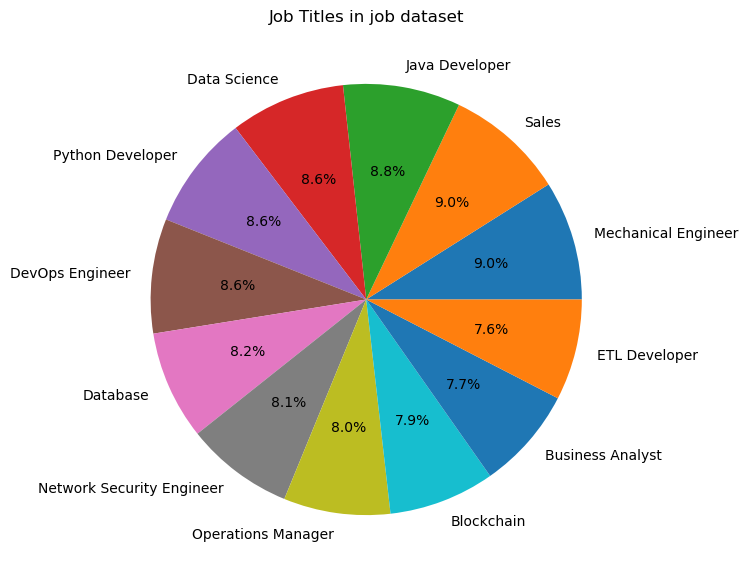

In [227]:
df_jobs = df_filtered.copy()
job_title_count = df_jobs['Job_Title_Searched'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(job_title_count, labels=job_title_count.index, autopct='%1.1f%%')
plt.title('Job Titles in job dataset')
plt.show()

### EDA of Resume dataset

In [228]:
df_resume['Category'].unique()

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

Example of a Resume:

In [229]:
print(df_resume['Category'][20])
print(df_resume['Resume'][20])

Data Science
Skills * Programming Languages: Python (pandas, numpy, scipy, scikit-learn, matplotlib), Sql, Java, JavaScript/JQuery. * Machine learning: Regression, SVM, NaÃ¯ve Bayes, KNN, Random Forest, Decision Trees, Boosting techniques, Cluster Analysis, Word Embedding, Sentiment Analysis, Natural Language processing, Dimensionality reduction, Topic Modelling (LDA, NMF), PCA & Neural Nets. * Database Visualizations: Mysql, SqlServer, Cassandra, Hbase, ElasticSearch D3.js, DC.js, Plotly, kibana, matplotlib, ggplot, Tableau. * Others: Regular Expression, HTML, CSS, Angular 6, Logstash, Kafka, Python Flask, Git, Docker, computer vision - Open CV and understanding of Deep learning.Education Details 

Data Science Assurance Associate 

Data Science Assurance Associate - Ernst & Young LLP
Skill Details 
JAVASCRIPT- Exprience - 24 months
jQuery- Exprience - 24 months
Python- Exprience - 24 monthsCompany Details 
company - Ernst & Young LLP
description - Fraud Investigations and Dispute Ser

Despite resumes can be usually considered as unstructured data, within the "Resume Screening" dataset they exhibit a close to structured format, commencing with the Skills section, followed by Education, and concluding with the Experience section.

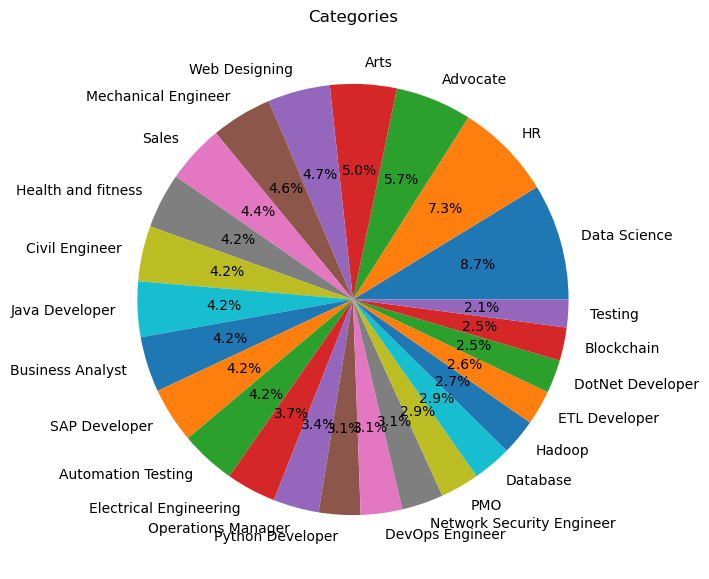

In [230]:
# Pie chart of the categories
plt.figure(figsize=(10, 7))
plt.pie(df_resume['Category'].value_counts(), labels=df_resume['Category'].unique(), autopct='%1.1f%%')
plt.title('Categories')
plt.show()

The resumes came with several different categories, some not related to the Data Science or technologies industry, will be dropped.

The remaining categories are then reduced to 12 job titles.

In [231]:
values_to_keep = ['Data Science','Mechanical Engineer', 'Sales','Java Developer', 'Business Analyst','Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'Database','Blockchain','ETL Developer']
df_resume['Category'] = df_resume['Category'].apply(lambda x: x if x in values_to_keep else 'NA')

df_resume = df_resume[df_resume['Category'] != 'NA']
df_resume = df_resume.reset_index()
print("Total number of CVs: ", df_resume.shape[0])
print(df_resume['Category'].value_counts())

Total number of CVs:  513
Category
Java Developer               84
DevOps Engineer              55
Python Developer             48
Data Science                 40
Mechanical Engineer          40
Sales                        40
Operations Manager           40
ETL Developer                40
Blockchain                   40
Database                     33
Business Analyst             28
Network Security Engineer    25
Name: count, dtype: int64


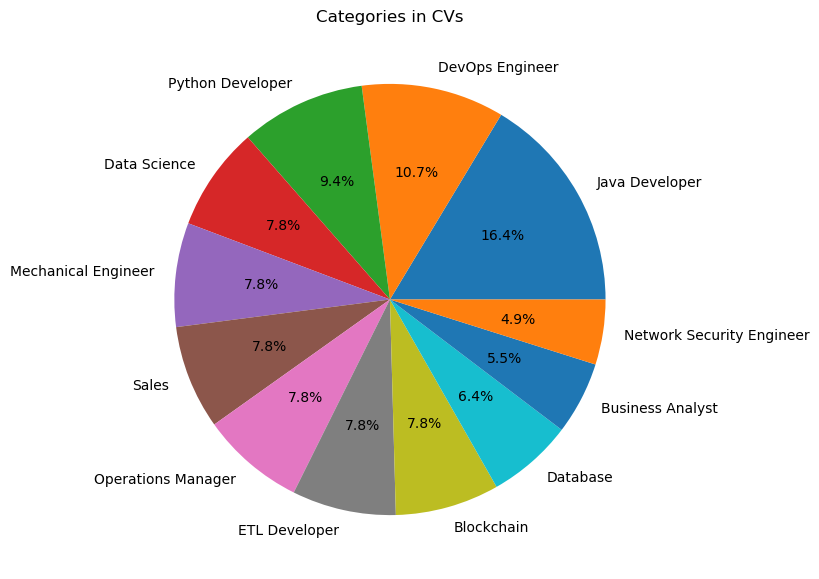

In [232]:
# Pie Chart of the categories in CVs
category_count = df_resume['Category'].value_counts()
plt.figure(figsize=(10, 7))
plt.pie(category_count, labels=category_count.index, autopct='%1.1f%%')
plt.title('Categories in CVs')
plt.show()

SImilar distribution of job titles as in the job offers dataset, main difference is the amount of Java Developers.

### Preprocessing Resumes:

In the resume dataset used for this project, most of the resumes follow a similar structure:
- Skills (not always present)
- Education Details
- Complete job title
- Skills Details -> Experience
- More details about experience/companies

We will use this information to parse the CVs and split their sections.



In [233]:
df_resume['Experience'] = df_resume['cleaned_resume'].apply(lambda x: (x.split("skill details", 1)[1]))
df_resume['Skills'] = None
df_resume['Education'] = None

for i in range(len(df_resume)):
    educ_and_skills = df_resume['cleaned_resume'].iloc[i].split('skill details', 1)[0]
    educ = educ_and_skills.split('education details', 1)[1]
    skills = educ_and_skills.split('education details', 1)[0]
    df_resume['Skills'].iloc[i] = skills
    df_resume['Education'].iloc[i] = educ


In [234]:
# Replace empty strings with NaN in the 'Skills' and 'Education' columns
df_resume['Skills'].replace('', np.nan, inplace=True)
df_resume['Education'].replace('', np.nan, inplace=True)
# Print the columns and number of missing values
print("Missing values: ")
print(df_resume.isnull().sum())
print(df_resume.shape)

Missing values: 
index               0
Category            0
Resume              0
cleaned_resume      0
Experience          0
Skills            118
Education           0
dtype: int64
(513, 7)


We can see that most of the sections have been split well using the split function, except for the skills section, that has several missing data.

### Creating id column:

In [235]:
df_jobs['id'] = np.arange(0,len(df_jobs), 1)
df_resume['id'] = np.arange(0,len(df_resume), 1)

## Skills extraction

Every job description has some specific skills that are required or requested. Depending on the job position these skills will change. Our objective is to predict job titles from their description and this practice will be enhanced by selecting the most required skills for each of the job titles.

To extract the skills we used spacy's Named Entity Recognition. We trained our own model labeling part of our data detecting 'Hard' and 'Soft' skills in the descriptions. The model was then applied to extract the skills from each of the descriptions and stored in two separate columns for 'Hard' and 'Soft' skills.

In [236]:
# Specify the file path where you saved the dictionary
file_path = "./data/train_data_ner.pkl"

# Open the file in binary read mode and load the dictionary using pickle
with open(file_path, 'rb') as file:
    loaded_data = pickle.load(file)

### Training NER Model

In [237]:
nlp = spacy.load("en_core_web_sm")

db = DocBin()

for text, annot in tqdm(loaded_data['annotations']):
        # print(text)
        # print(annot)
        doc = nlp.make_doc(text)
        ents = []
        for start, end, label in annot["entities"]:
            span = doc.char_span(start, end, label=label, alignment_mode="contract")
            if span is None:
                print("Skipping entity")
            else:
                ents.append(span)
        doc.ents = ents
        db.add(doc)

db.to_disk("./training_data_skills.spacy") 

100%|██████████| 261/261 [00:00<00:00, 834.66it/s] 


Loading the model and testing it on a random description.

In [238]:
ner_model = spacy.load("./model-last") #load the best model
doc = ner_model("california policy lab california policy lab translates research insights government impact hands partnerships government agencies cpl performs rigorous research across issue silos builds data infrastructure necessary improve programs policies millions californians rely every day cpl ucla site dynamic growing organization nearly full time employees half dozen graduate student researchers numerous faculty affiliates cpl recognizes value diverse staff levels organization looking equity minded applicants represent understand diverse racial ethnic gender identity sexual orientation educational socioeconomic cultural disability backgrounds present california join team expect part inclusive equity focused community role california policy lab seeking experienced data analyst contribute organization proven track record bridging gap academic researchers government policymakers data analyst opportunity apply methodologies econometrics statistics data science original research projects primarily focused homelessness mental health social safety net data analyst may embed public agencies los angeles support collaborative research partnerships successful candidate well versed data manipulation wrangling cleaning experience running testing interpreting variety statistical models passionate using data find innovative solutions problems facing california policymakers citizens position requires individual able work part small research teams running multiple projects concurrently seek highly organized individuals superior written verbal skills excellent time management data analyst also required follow coding guidelines established cpl contribute organization efforts build richly detailed documentation data use applicants must bachelor degree public policy economics statistics relevant field equivalent experience training master degree preferred applicants must also least one year relevant research experience experience gained school counts toward requirement two three years professional post baccalaureate experience preferred percentage time shift start shift end pm qualifications position records qualifications required preferred strong interest applied policy questions homelessness mental health poverty social services required mastery data analysis data visualization python r stata required superior verbal written communication skills required attention detail ability organize document workflow required strong initiative resourceful approach problem solving required ability work independently part team required ability multi task demanding timeframes required ability work discreetly sensitive confidential data required substantive knowledge experience least one core research areas homelessness health criminal justice poverty education labor preferred understanding relational databases mastery data analysis data management sql preferred substantive knowledge quantitative research methods causal inference preferred experience working academic think tank environment preferred project management experience preferred experience business intelligence tools tableau powerbi preferred experience predictive modeling machine learning artificial intelligence preferred additional posting information bargaining unit policy covered application deadline external posting date") # input sample text

spacy.displacy.render(doc, style="ent", jupyter=True)

We can see from the random example that the model is detecting very well the hard and soft skills in the text. After testing the model on several examples and adding more labelled data we were satisfied with the performance and proceeded to the implementation on all our available data.

### Applying model

In [239]:
# Load your trained model
nlp1 = spacy.load("./model-last")

# Assuming df_new is your DataFrame with the job descriptions
df_jobs['hard_skills'] = ''
df_jobs['soft_skills'] = ''
df_resume['hard_skills'] = ''
df_resume['soft_skills'] = ''

# Function to extract hard and soft skills from a text using the trained model
def extract_skills(text):
    doc = nlp1(text)
    # print(doc)
    hard_skills = []
    soft_skills = []
    for ent in doc.ents:
        if ent.label_ == ('HARD_SKILL') or ent.label_ == 'HARD SKILL':
            hard_skills.append(ent.text)
        elif ent.label_ == ('SOFT_SKILL' ) or ent.label_ == 'SOFT SKILL':
            soft_skills.append(ent.text)
    return hard_skills, soft_skills

# Apply the function to each row in the Job DataFrame
for index, row in df_jobs.iterrows():
    text = row['cleaned_description']
    hard_skills, soft_skills = extract_skills(text)
    df_jobs.at[index, 'hard_skills'] = hard_skills
    df_jobs.at[index, 'soft_skills'] = soft_skills

# Apply the function to each row in the Resume DataFrame
for index, row in df_resume.iterrows():
    text = row['cleaned_resume'] # TODO: Try 'Skills' column has less text but could be more relevant
    hard_skills, soft_skills = extract_skills(text)
    df_resume.at[index, 'hard_skills'] = hard_skills
    df_resume.at[index, 'soft_skills'] = soft_skills

# Display the resulting DataFrame for df_jobs
df_jobs[['hard_skills', 'soft_skills']].head()

,hard_skills,soft_skills
0,"[data analyst, cleaning, statistical, data ana...",[communication]
1,"[data mining, statistics, machine learning, al...",[communication]
2,"[algorithms, algorithms, ai, develop, algorith...","[communication, organizational, prioritize, ma..."
6,"[analytics, programming, quantitative analysis...","[strategic, strategic, communication]"
7,"[statistical, dashboards, dashboards, statisti...",[]


The list of strings were then turned into a single string that will then be concatenated to the text to improve clustering done with Vectorization and LDA
.

In [240]:
# Convert lists to strings for 'hard_skills' and 'soft_skills' columns
df_jobs['hard_skills'] = df_jobs['hard_skills'].apply(lambda x: ' '.join(x))
df_jobs['soft_skills'] = df_jobs['soft_skills'].apply(lambda x: ' '.join(x))
df_resume['hard_skills'] = df_resume['hard_skills'].apply(lambda x: ' '.join(x))
df_resume['soft_skills'] = df_resume['soft_skills'].apply(lambda x: ' '.join(x))

To emphasize the importance of the skills in both jobs and resume datasets, the skills that were extracted using the self trained spacy's Named Entity Recognition. We add the extracted skills multiple times to each description/resume, to higher the frequency of the skills token.

In [241]:
# Concatenate the processed_description, hard_skills, and soft_skills columns
df_jobs['cleaned_text_skills'] = df_jobs['cleaned_description'] + ' ' + 3*df_jobs['hard_skills'] + ' ' + 3*df_jobs['soft_skills']
df_jobs['cleaned_extracted_skills'] = df_jobs['cleaned_extracted_description'] + ' ' + 3*df_jobs['hard_skills'] + ' ' + 3*df_jobs['soft_skills']
df_resume['cleaned_resume_skills'] = df_resume['cleaned_resume'] + ' ' + 3*df_resume['hard_skills'] + ' ' + 3*df_resume['soft_skills']

## LDA analysis

### Document Term Matrix

In [242]:
# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
vectorizer = TfidfVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X = vectorizer.fit_transform(df_jobs['cleaned_text_skills'])

# Convert DTM to DataFrame
dtm_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
display(dtm_df)
dtm_df.shape

abilities  ability work      able  access  accommodation  \
0           0.0      0.073351  0.032635  0.0000       0.000000   
1           0.0      0.000000  0.000000  0.0000       0.000000   
2           0.0      0.000000  0.026495  0.0000       0.000000   
3           0.0      0.040185  0.000000  0.0000       0.000000   
4           0.0      0.000000  0.000000  0.0000       0.000000   
...         ...           ...       ...     ...            ...   
1870        0.0      0.000000  0.000000  0.0000       0.055408   
1871        0.0      0.000000  0.033155  0.0000       0.000000   
1872        0.0      0.000000  0.037140  0.0000       0.000000   
1873        0.0      0.000000  0.038112  0.0374       0.000000   
1874        0.0      0.000000  0.038112  0.0374       0.000000   

      accommodations  account  accounts  accuracy  accurate  achieve  \
0                0.0  0.00000  0.000000  0.000000       0.0      0.0   
1                0.0  0.00000  0.000000  0.000000       0.0      0.0   
2                0.0  0.00000  0.000000  0.000000       0.0      0.0   
3                0.0  0.00000  0.052188  0.000000       0.0      0.0   
4                0.0  0.00000  0.000000  0.044307       0.0      0.0   
...              ...      ...       ...       ...       ...      ...   
1870             0.0  0.00000  0.000000  0.000000       0.0      0.0   
1871             0.0  0.00000  0.000000  0.000000       0.0      0.0   
1872             0.0  0.04804  0.000000  0.000000       0.0      0.0   
1873             0.0  0.00000  0.000000  0.000000       0.0      0.0   
1874             0.0  0.00000  0.000000  0.000000       0.0      0.0   

           act    action  action employer  actionable  actions    active  \
0     0.000000  0.000000         0.000000    0.000000      0.0  0.000000   
1     0.000000  0.000000         0.000000    0.000000      0.0  0.000000   
2     0.000000  0.000000         0.000000    0.000000      0.0  0.000000   
3     0.000000  0.000000         0.000000    0.000000      0.0  0.000000   
4     0.000000  0.000000         0.000000    0.088109      0.0  0.000000   
...        ...       ...              ...         ...      ...       ...   
1870  0.000000  0.058272         0.036061    0.000000      0.0  0.038839   
1871  0.000000  0.037222         0.000000    0.000000      0.0  0.000000   
1872  0.052011  0.000000         0.000000    0.000000      0.0  0.000000   
1873  0.000000  0.000000         0.000000    0.000000      0.0  0.000000   
1874  0.000000  0.000000         0.000000    0.000000      0.0  0.000000   

      actively  activities  actual   ad  addition  additional  \
0     0.000000    0.000000     0.0  0.0       0.0    0.029257   
1     0.000000    0.000000     0.0  0.0       0.0    0.000000   
2     0.000000    0.000000     0.0  0.0       0.0    0.000000   
3     0.000000    0.000000     0.0  0.0       0.0    0.000000   
4     0.039157    0.000000     0.0  0.0       0.0    0.000000   
...        ...         ...     ...  ...       ...         ...   
1870  0.034845    0.000000     0.0  0.0       0.0    0.000000   
1871  0.000000    0.000000     0.0  0.0       0.0    0.059447   
1872  0.000000    0.000000     0.0  0.0       0.0    0.033297   
1873  0.025585    0.041681     0.0  0.0       0.0    0.068334   
1874  0.025585    0.041681     0.0  0.0       0.0    0.068334   

      additional information   address  administration  advanced  affirmative  \
0                   0.000000  0.000000        0.000000  0.000000     0.000000   
1                   0.000000  0.000000        0.000000  0.018698     0.000000   
2                   0.000000  0.032738        0.000000  0.028528     0.000000   
3                   0.000000  0.000000        0.000000  0.000000     0.000000   
4                   0.000000  0.000000        0.000000  0.000000     0.000000   
...                      ...       ...             ...       ...          ...   
1870                0.000000  0.000000        0.000000  0.027944     0.065421   
1871  

(1875, 1000)

### Latent Dirichlet Allocation (LDA):

In [243]:
# def get_lda_topics(dtm,num_topics):    
#     #gensim needs the dtm in a different sparce format
#     dtm_sparse = csr_matrix(dtm)

#     # Convert sparse matrix to gensim corpus
#     corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

#     # Create gensim dictionary from sklearn CountVectorizer vocabulary
#     vocabulary_gensim = {}
#     for key, val in vectorizer.vocabulary_.items():
#         vocabulary_gensim[val] = key

#     dictionary = corpora.Dictionary()
#     dictionary.id2token = vocabulary_gensim
#     dictionary.token2id = vectorizer.vocabulary_

#     # Train LDA model
#     lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
#     return lda_model, corpus, dictionary


In [244]:
# # Number of topics
# num_topics = 12

# # Build LDA model
# lda_model, corpus, dic = get_lda_topics(dtm_df, num_topics)

# # Display the topics
# topics = lda_model.print_topics(num_words=30)
# for topic in topics:
#     print(topic)
#     print()

In [245]:
# # Using get_document_topics with an explicit minimum_probability
# doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.3) for item in corpus]

# # Consider using [lda[item]
# # 
# #  for item in corpus] but this has a higher threshold. 
# print(doc_topics[1180])    

In [246]:
# empty_topics = [x for x in range (len(doc_topics)) if len(doc_topics[x])==0]
# more_than_one_topic = [x for x in range (len(doc_topics)) if len(doc_topics[x])>1]

# print(f'Number of descriptions with no topic: {len(empty_topics)}')
# print(f'Number of descriptions with more than one topics: {len(more_than_one_topic)}')

In [247]:
# topics = lda_model.show_topics(num_topics=-1, num_words=50, formatted=False)
# display(topics)

In [248]:
# def generate_wordclouds(topics, dictionary):
#     for topic_num, topic_words in topics:
#         word_freq = dict(topic_words)
#         wordcloud = WordCloud(
#             width = 800,
#             height = 600,
#             background_color ='white',
#             color_func=lambda *args, **kwargs: "black", # Ensures words are in black
#             min_font_size = 10).generate_from_frequencies(word_freq)
        
#         plt.figure(figsize = (6, 6), facecolor = None)
#         plt.imshow(wordcloud, interpolation="bilinear")
#         plt.axis("off")
#         plt.title(f'Topic #{topic_num}')
#         plt.show()

# # Generate word clouds for each topic
# generate_wordclouds(topics, lda_model.id2word)

The topics will be matched based on the most common words to the most probable jobs they should be referring to using human feedback and then results will be analyzed.

### Results

In [249]:
# # Function to get the most probable topic for a document
# def get_most_probable_topic(lda_model, document):
#     topics = lda_model.get_document_topics(document, minimum_probability=0.2)
#     if topics:
#         return max(topics, key=lambda x: x[1])[0]
#     else:
#         return "Other"

# # Apply the function to each document in the corpus
# df_jobs['Cluster_job_title'] = [get_most_probable_topic(lda_model, doc) for doc in corpus]

# # Map the topic numbers to your specified categories, one of the 12 job titles:
# # 'Data Science','Mechanical Engineer','Sales','Java Developer', 'Business Analyst','Operations Manager', 'Python Developer', 'DevOps Engineer',
# # 'Network Security Engineer', 'Database','Blockchain','ETL Developer'
# topic_mapping = {
#     0: 'Sales',
#     1: 'Java Developer',
#     2: 'Database',
#     3: 'ETL Developer',
#     4: 'Data Science',
#     5: 'DevOps Engineer',
#     6: 'Blockchain',
#     7: 'Business Analyst',
#     8: 'Network Security Engineer',
#     9: 'Python Developer',
#     10: 'Operations Manager',
#     11: 'Mechanical Engineer'
# }
# df_jobs['Cluster_job_title'] = df_jobs['Cluster_job_title'].map(topic_mapping)

# # Fill NA values with 'Other'
# df_jobs['Cluster_job_title'].fillna('Other', inplace=True)

# # Display or use df_new with the new 'Cluster_job_title' column
# display(df_jobs[['Job_Title_Searched', 'Cluster_job_title']])

Looking at the results of the matching having a quick skim of the predicted data we can obviously see that the performance just based on the topics of the LDA was really poor. The matching of the topics to the job was done manually, so this can create a problem when testing its performance.

### Coherence of Topics

In [250]:
# cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
# coherence = cm.get_coherence()  # get coherence value
# coherence

### Plotting LDA Topics

In [251]:
# vis_data = gensimvis.prepare(lda_model, corpus, dic)
# pyLDAvis.display(vis_data)

From the graph we can see that most of the topics are overlapping except for a few isolated examples that represent a small percent of the tokens involved. This means that LDA is not a good performing model for this type of task. The reason for this is that the jobs chosen can be very far away in terms of topics (i.e. 'Sales' vs 'Network security engineer'), but also very close (i.e. 'Python developer' vs 'Java developer'). Therefore, just using the LDA topics will give results that are close to random. We will test different other methodologies to perform the matching task.

# LDA on a few job titles

### Model: LDA

In [252]:
# # Number of topics
# num_topics = 12

# # Build LDA model
# lda_model, corpus, dic = get_lda_topics(dtm_df, num_topics)

# # Apply the function to each document in the corpus
# df_jobs['pred_LDA'] = [get_most_probable_topic(lda_model, doc) for doc in corpus]

# # Map the topic numbers to your specified categories
# df_jobs['pred_LDA'] = df_jobs['pred_LDA'].map(topic_mapping)

# # Fill NA values with 'Other'
# df_jobs['pred_LDA'].fillna('Other', inplace=True)

Metrics:

In [253]:
# y_true = df_jobs['Job_Title_Searched']
# y_pred = df_jobs['pred_LDA']
# metrics.run(y_true, y_pred, 'LDA')
# metrics.plot()

# Model comparison for Job offers


In this section we will compare the different performances of the models in predicting the job title of each job posting just using its text. We will evntually evaluate the results.

### Preprocessing

In [254]:
# modulation: 0 -> remove stop words, 1 -> remove stop words and stem words, 2 -> remove stop words and lemmatize words
df_jobs["cleaned_description"] = df_jobs["cleaned_description"].apply(tokenize, modulation=1)
df_jobs["cleaned_text_skills"] = df_jobs["cleaned_text_skills"].apply(tokenize, modulation=1) 
df_jobs["cleaned_extracted_description"] = df_jobs["cleaned_extracted_description"].apply(lambda x: x if x is np.nan else tokenize(x, modulation=1))

df_resume["cleaned_resume_skills"] = df_resume["cleaned_resume_skills"].apply(tokenize, modulation=1)
df_resume["cleaned_resume"] = df_resume["cleaned_resume"].apply(tokenize, modulation=1)

metrics = Metrics()

### Document Term Matrix

In [255]:
# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
vec = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X_cts = vec.fit_transform(df_jobs['cleaned_text_skills'])
vectorized_jobs_cts = X_cts.todense()
dtm_df_cts = pd.DataFrame(X_cts.toarray(), columns=vec.get_feature_names_out())

vec = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X_cd = vec.fit_transform(df_jobs['cleaned_description'])
vectorized_jobs_cd = X_cd.todense()
dtm_df_cd = pd.DataFrame(X_cd.toarray(), columns=vec.get_feature_names_out())

vec = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
X_ced = vec.fit_transform(df_jobs['cleaned_extracted_description'].dropna())
vectorized_jobs_ced = X_ced.todense()
dtm_df_ced = pd.DataFrame(X_ced.toarray(), columns=vec.get_feature_names_out())

### Model: Cosine Similarity (mode) 
- using mode of 10 best fits



Matches with every job posting and stores the 10 job titles that held the highest values for cosine similarity. Then takes the mode of the one appearing the most.

In [256]:
# Initialize a dictionary to store the top 10 matches for each job offer
matching_dictionary = {}

# Iterate through each job oofer and find the top 10 matches
for j_id, j_vector in enumerate(vectorized_jobs_cts):
    similarities = {}
    top_matches = []
    for job_id, job_vector in enumerate(vectorized_jobs_cts):
        similarity = float(cosine_similarity(j_vector, job_vector))
        # Sort the dictionary based on values in ascending order
        if len(similarities)<10:
            similarities[job_id]=similarity
        elif similarity>next(iter(similarities.values())):
            first_key = next(iter(similarities))
            similarities[job_id] = similarity
            del similarities[first_key]
        similarities = dict(sorted(similarities.items(), key=lambda item: item[1]))
    # top_matches = similarities[-10:][::-1]  # Get indices of top 10 matches
    matching_dictionary[j_id] = similarities

In [257]:
# Create a DataFrame to store the results
columns = [f"Match_{i+1}" for i in range(10)]
result_df = pd.DataFrame(columns=columns)

# Iterate through each job offer in df_new and extract the top 10 job titles
for job_id, matches in matching_dictionary.items():
    job_ids = list(matches.keys())
    job_titles = df_jobs.loc[df_jobs['id'].isin(job_ids), 'Job_Title_Searched'].tolist()
    result_df.loc[job_id] = job_titles

# Reset index of result_df
result_df.reset_index(drop=True, inplace=True)
df_jobs.reset_index(drop=True, inplace=True)

# Function to find the most common element in a list
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

# Add 'Predicted_job' column based on the most common job title in each row
result_df['job_title_mode_cs'] = result_df.apply(lambda row: most_common(row), axis=1)

# Fill NA values with 'Other'
result_df['job_title_mode_cs'].fillna('Other', inplace=True)

if len(result_df) == len(df_jobs):
    df_jobs['job_title_mode_cs'] = result_df['job_title_mode_cs']

In [258]:
y_true = df_jobs['Job_Title_Searched']
y_pred = df_jobs['job_title_mode_cs']
metrics.run(y_true, y_pred, 'CS_Mode')

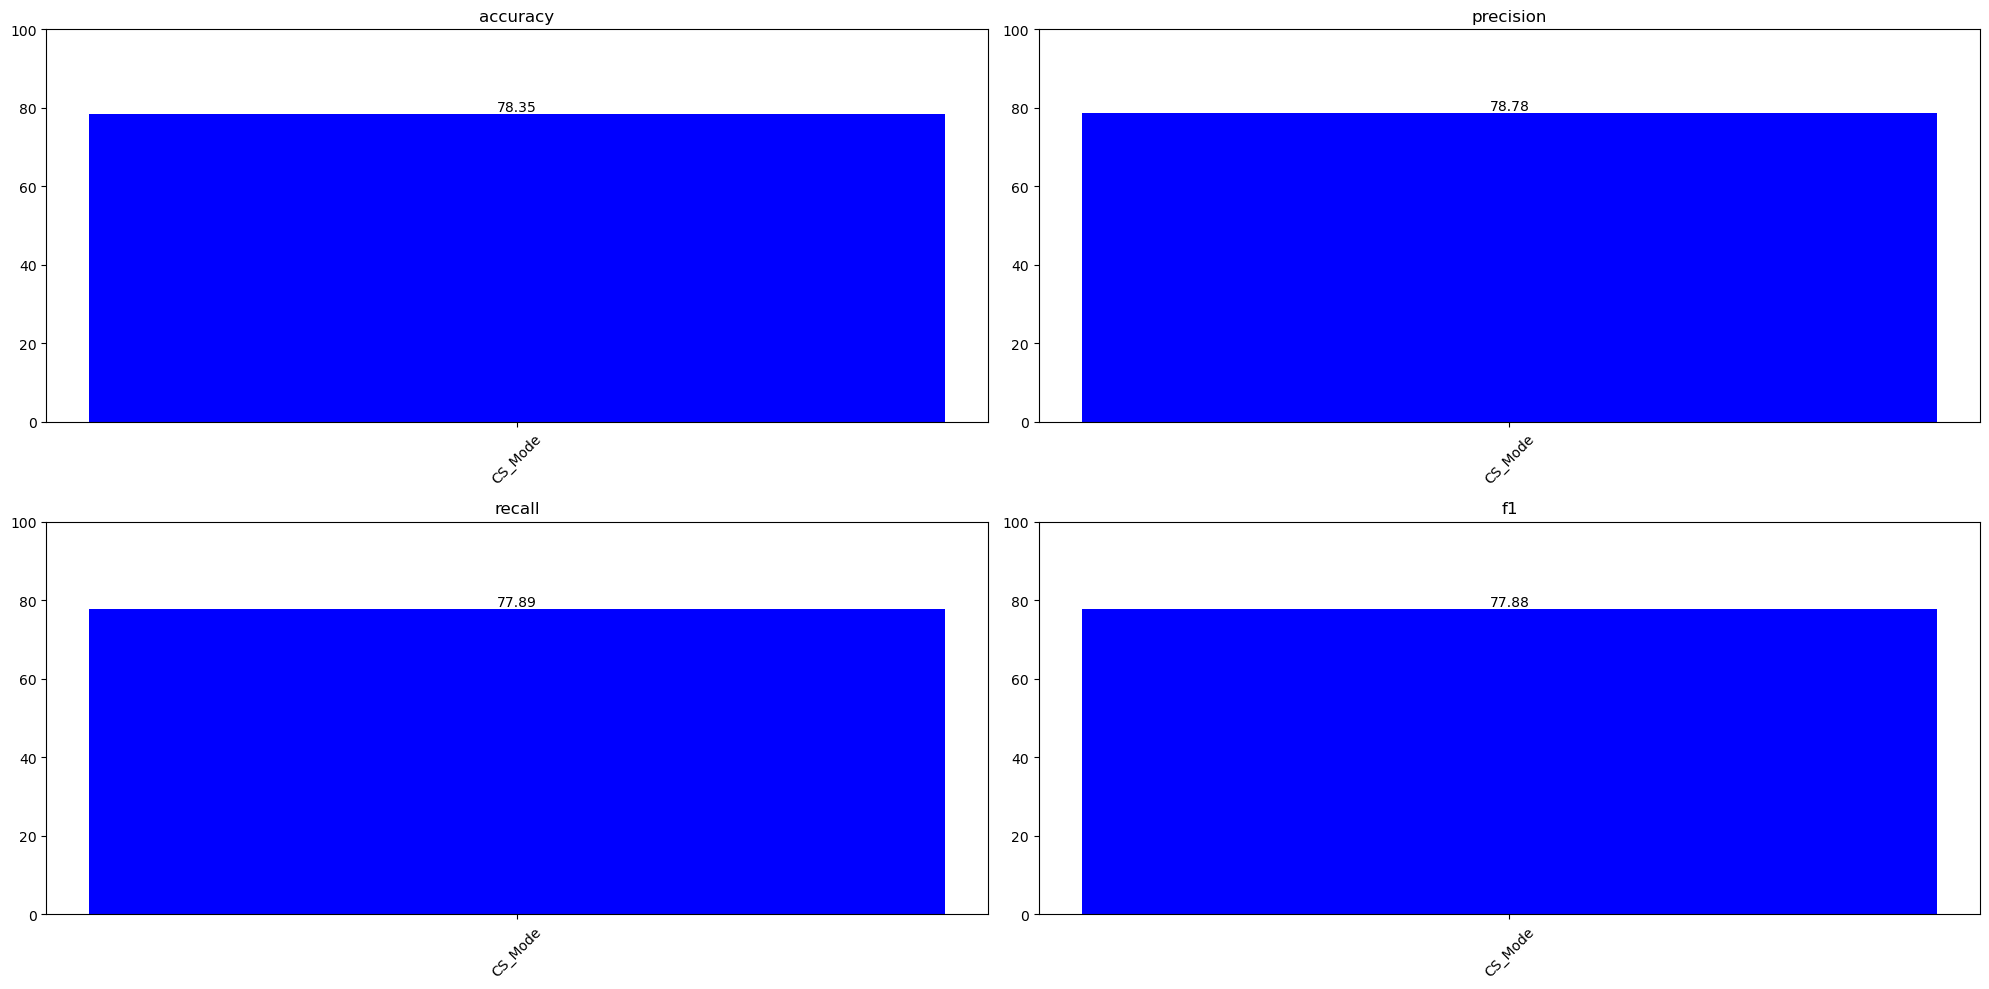

In [259]:
metrics.plot()

### Model: Cosine similarity (average)
- using average best fit per group of job title

This second model approach computes the average cosine similarity between each job title and then picks the job title which held the highest average cosine similarity as follows. 

In [260]:
df_jobs

,Job_Title_Searched,Description,cleaned_description,cleaned_extracted_description,description_length,id,hard_skills,soft_skills,cleaned_text_skills,cleaned_extracted_skills,job_title_mode_cs
0,Data Science,About the California Policy Lab\nThe Californi...,california polici lab california polici lab tr...,california polici lab california polici lab tr...,565.0,0,data analyst cleaning statistical data analyst...,communication,california polici lab california polici lab tr...,california policy lab california policy lab tr...,Data Science
1,Data Science,Job Description\nThe Research Data Scientist p...,job descript research data scientist particip ...,job descript research data scientist particip ...,2553.0,1,data mining statistics machine learning algori...,communication,job descript research data scientist particip ...,job description research data scientist partic...,Data Science
2,Data Science,Expatiate Communications is a boutique managem...,expati communic boutiqu manag consult firm unm...,expati communic boutiqu manag consult firm unm...,2153.0,2,algorithms algorithms ai develop algorithms ai...,communication organizational prioritize manage...,expati communic boutiqu manag consult firm unm...,expatiate communications boutique management c...,Data Science
3,Data Science,"Los Angeles, California\nFinance\nNetflix is t...",los angel california financ netflix world lead...,los angel california financ netflix world lead...,2311.0,3,analytics programming quantitative analysis mo...,strategic strategic communication,los angel california financ netflix world lead...,los angeles california finance netflix world l...,Business Analyst
4,Data Science,POSITION SUMMARY\nTapBlaze is looking for an a...,posit summari tapblaz look ambiti innov produc...,posit summari tapblaz look ambiti innov produc...,2821.0,4,statistical dashboards dashboards statistical ...,,posit summari tapblaz look ambiti innov produc...,position summary tapblaze looking ambitious in...,Data Science
...,...,...,...,...,...,...,...,...,...,...,...
1870,ETL Developer,KeyLogic is actively seeking a Data Architect ...,keylog activ seek data architect design develo...,keylog activ seek data architect design develo...,2712.0,1870,pipelines aws cloud aws cloud data data cloud ...,high quality solutions keylogic,keylog activ seek data architect design develo...,keylogic actively seeking data architect desig...,DevOps Engineer
1871,ETL Developer,About the Opportunity\nThis job description is...,opportun job descript intend describ general n...,opportun job descript intend describ general n...,3950.0,1871,computer science java python javascript databa...,communication presentation motivated organizat...,opportun job descript intend describ general n...,opportunity job description intended describe ...,ETL Developer
1872,ETL Developer,SS&C is a global provider of investment and fi...,ss c global provid invest financi servic softw...,ss c global provid invest financi servic softw...,1092.0,1872,c etl r machine learning snowflake programming...,creativity,ss c global provid invest financi servic softw...,ss c global provider investment financial serv...,ETL Developer
1873,ETL Developer,Job Summary\nThe Kempner Institute for the Stu...,job summari kempner institut studi natur artif...,job summari kempner institut studi natur artif...,3974.0,1873,artificial intelligence artificial contexts ma...,communication problem solving collaborative pr...,job summari kempner institut studi natur artif...,job summary kempner institute study natural ar...,Data Science


In [261]:
# Initialize dictionaries to store the similarity scores and average similarity for each job offer and cluster
similarity_scores_dictionary = {}
average_similarity_dictionary = {}

# Iterate through each job offer and find the similarity scores for each cluster
for j_id, j_vector in enumerate(vectorized_jobs_cts):
    cluster_similarities = {cluster: [] for cluster in df_jobs['Job_Title_Searched'].unique()}
    
    for job_id, job_vector in enumerate(vectorized_jobs_cts):
        similarity = float(cosine_similarity(j_vector, job_vector))
        cluster = df_jobs.loc[df_jobs['id'] == job_id, 'Job_Title_Searched'].iloc[0]
        cluster_similarities[cluster].append(similarity)
    
    # Store the similarity scores in the dictionary
    similarity_scores_dictionary[j_id] = cluster_similarities

    # Compute the average similarity for each cluster
    average_similarity = {f"{cluster}": np.mean(similarities) for cluster, similarities in cluster_similarities.items()}
    
    # Store the results in the dictionary
    average_similarity_dictionary[j_id] = average_similarity

,Job_Title_Searched,Description,cleaned_description,cleaned_extracted_description,description_length,id,hard_skills,soft_skills,cleaned_text_skills,cleaned_extracted_skills,job_title_mode_cs,job_title_avg_cs
0,Data Science,About the California Policy Lab\nThe Californi...,california polici lab california polici lab tr...,california polici lab california polici lab tr...,565.0,0,data analyst cleaning statistical data analyst...,communication,california polici lab california polici lab tr...,california policy lab california policy lab tr...,Data Science,Data Science
1,Data Science,Job Description\nThe Research Data Scientist p...,job descript research data scientist particip ...,job descript research data scientist particip ...,2553.0,1,data mining statistics machine learning algori...,communication,job descript research data scientist particip ...,job description research data scientist partic...,Data Science,Data Science
2,Data Science,Expatiate Communications is a boutique managem...,expati communic boutiqu manag consult firm unm...,expati communic boutiqu manag consult firm unm...,2153.0,2,algorithms algorithms ai develop algorithms ai...,communication organizational prioritize manage...,expati communic boutiqu manag consult firm unm...,expatiate communications boutique management c...,Data Science,Data Science
3,Data Science,"Los Angeles, California\nFinance\nNetflix is t...",los angel california financ netflix world lead...,los angel california financ netflix world lead...,2311.0,3,analytics programming quantitative analysis mo...,strategic strategic communication,los angel california financ netflix world lead...,los angeles california finance netflix world l...,Business Analyst,Business Analyst
4,Data Science,POSITION SUMMARY\nTapBlaze is looking for an a...,posit summari tapblaz look ambiti innov produc...,posit summari tapblaz look ambiti innov produc...,2821.0,4,statistical dashboards dashboards statistical ...,,posit summari tapblaz look ambiti innov produc...,position summary tapblaze looking ambitious in...,Data Science,Data Science


In [ ]:
# Create DataFrames for average similarity and similarity scores
average_similarity_df = pd.DataFrame(average_similarity_dictionary).T

# Add columns to the existing DataFrame
df_result = pd.concat([df_jobs, average_similarity_df], axis=1, join='inner')

# Add a column for the predicted cluster based on the highest average similarity
df_result['job_title_avg_cs'] = df_result.loc[:, average_similarity_df.columns].idxmax(axis=1)

# Fill NA values with 'Other'
df_result['job_title_avg_cs'].fillna('Other', inplace=True)
# Reset index of result_df
result_df.reset_index(drop=True, inplace=True)
df_jobs.reset_index(drop=True, inplace=True)

if len(result_df) == len(df_jobs):
    df_jobs['job_title_avg_cs'] = df_result['job_title_avg_cs']

# Display or use df_result as needed
df_jobs.head()

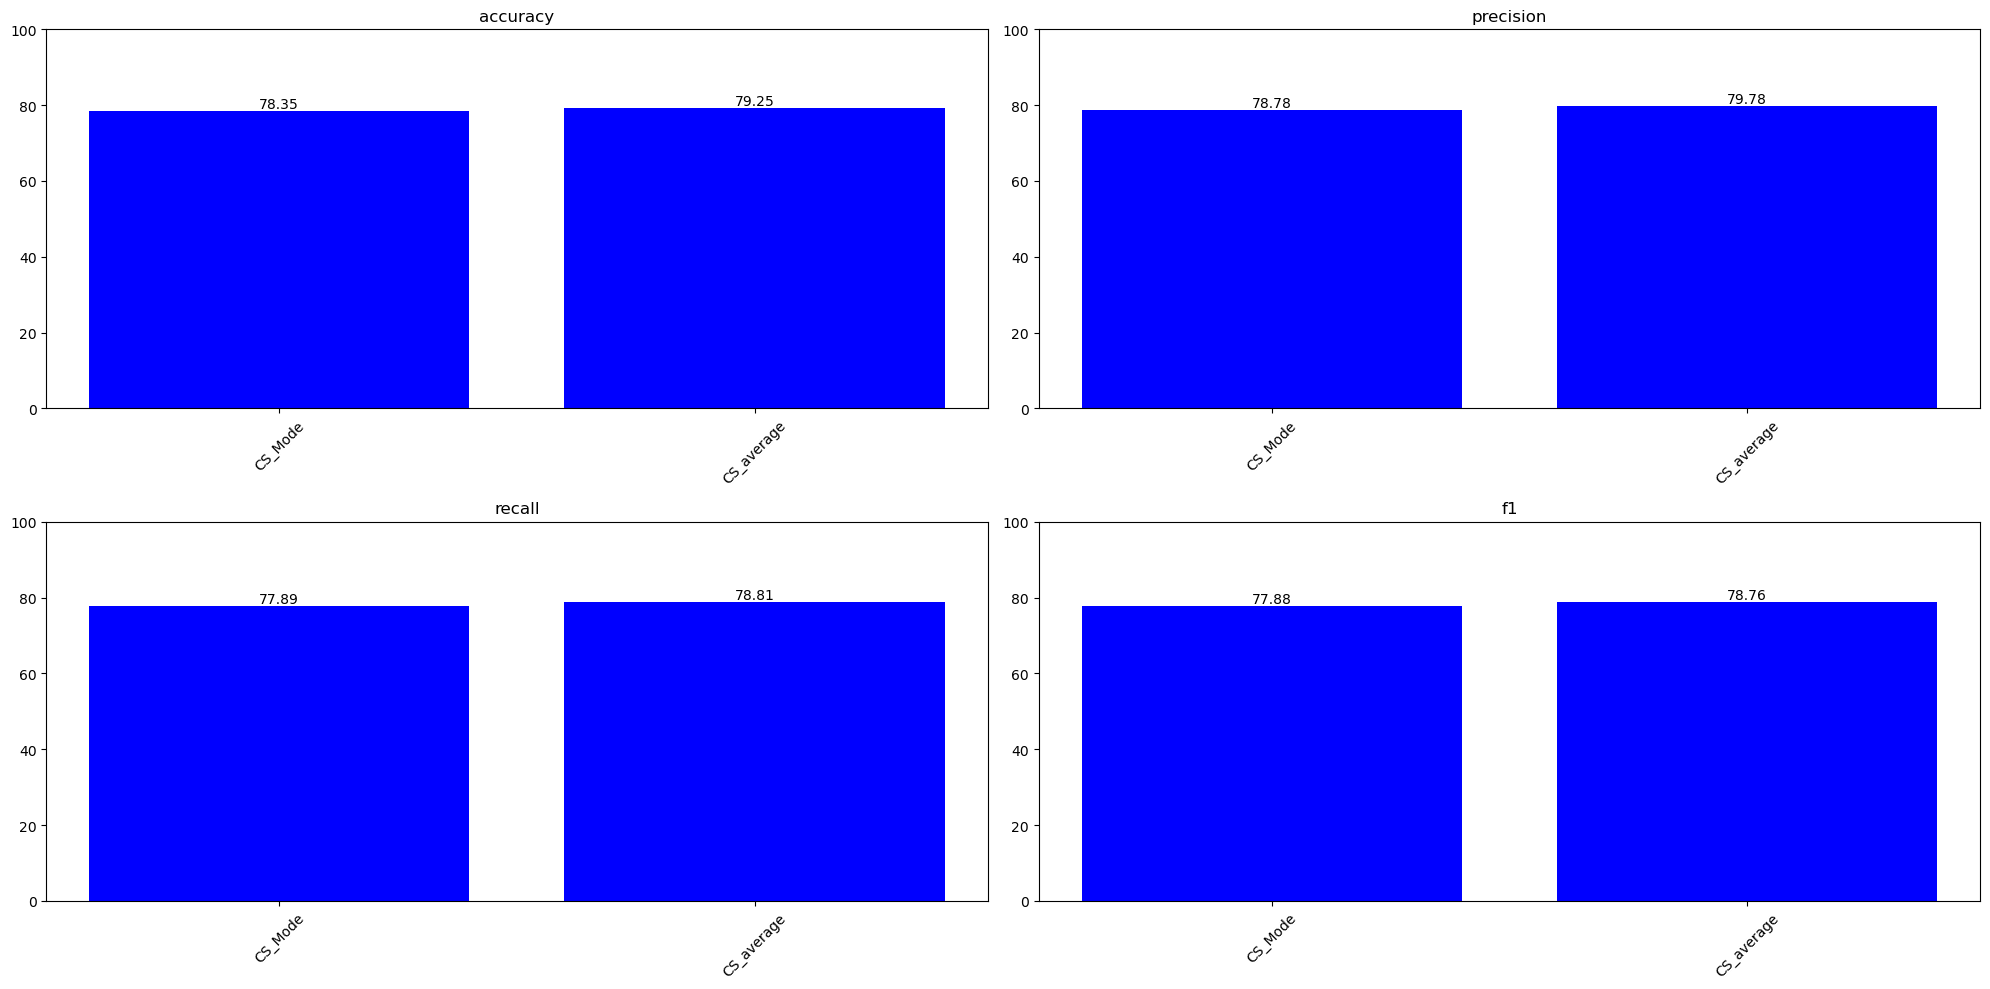

In [262]:
y_true = df_jobs["Job_Title_Searched"]
y_pred = df_jobs["job_title_avg_cs"]
metrics.run(y_true, y_pred, 'CS_average')
metrics.plot()

### Model: Logistic Regression

This model will compute a Logistic Regression model after TF-IDF vectorization on the text to predict the job title.

Performing logistic regression on column: cleaned_description


Best Parameters for column cleaned_description: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.02, 'tfidf__ngram_range': (1, 2)}
Performing logistic regression on column: cleaned_text_skills
Best Parameters for column cleaned_text_skills: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Performing logistic regression on column: cleaned_extracted_description
Best Parameters for column cleaned_extracted_description: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}


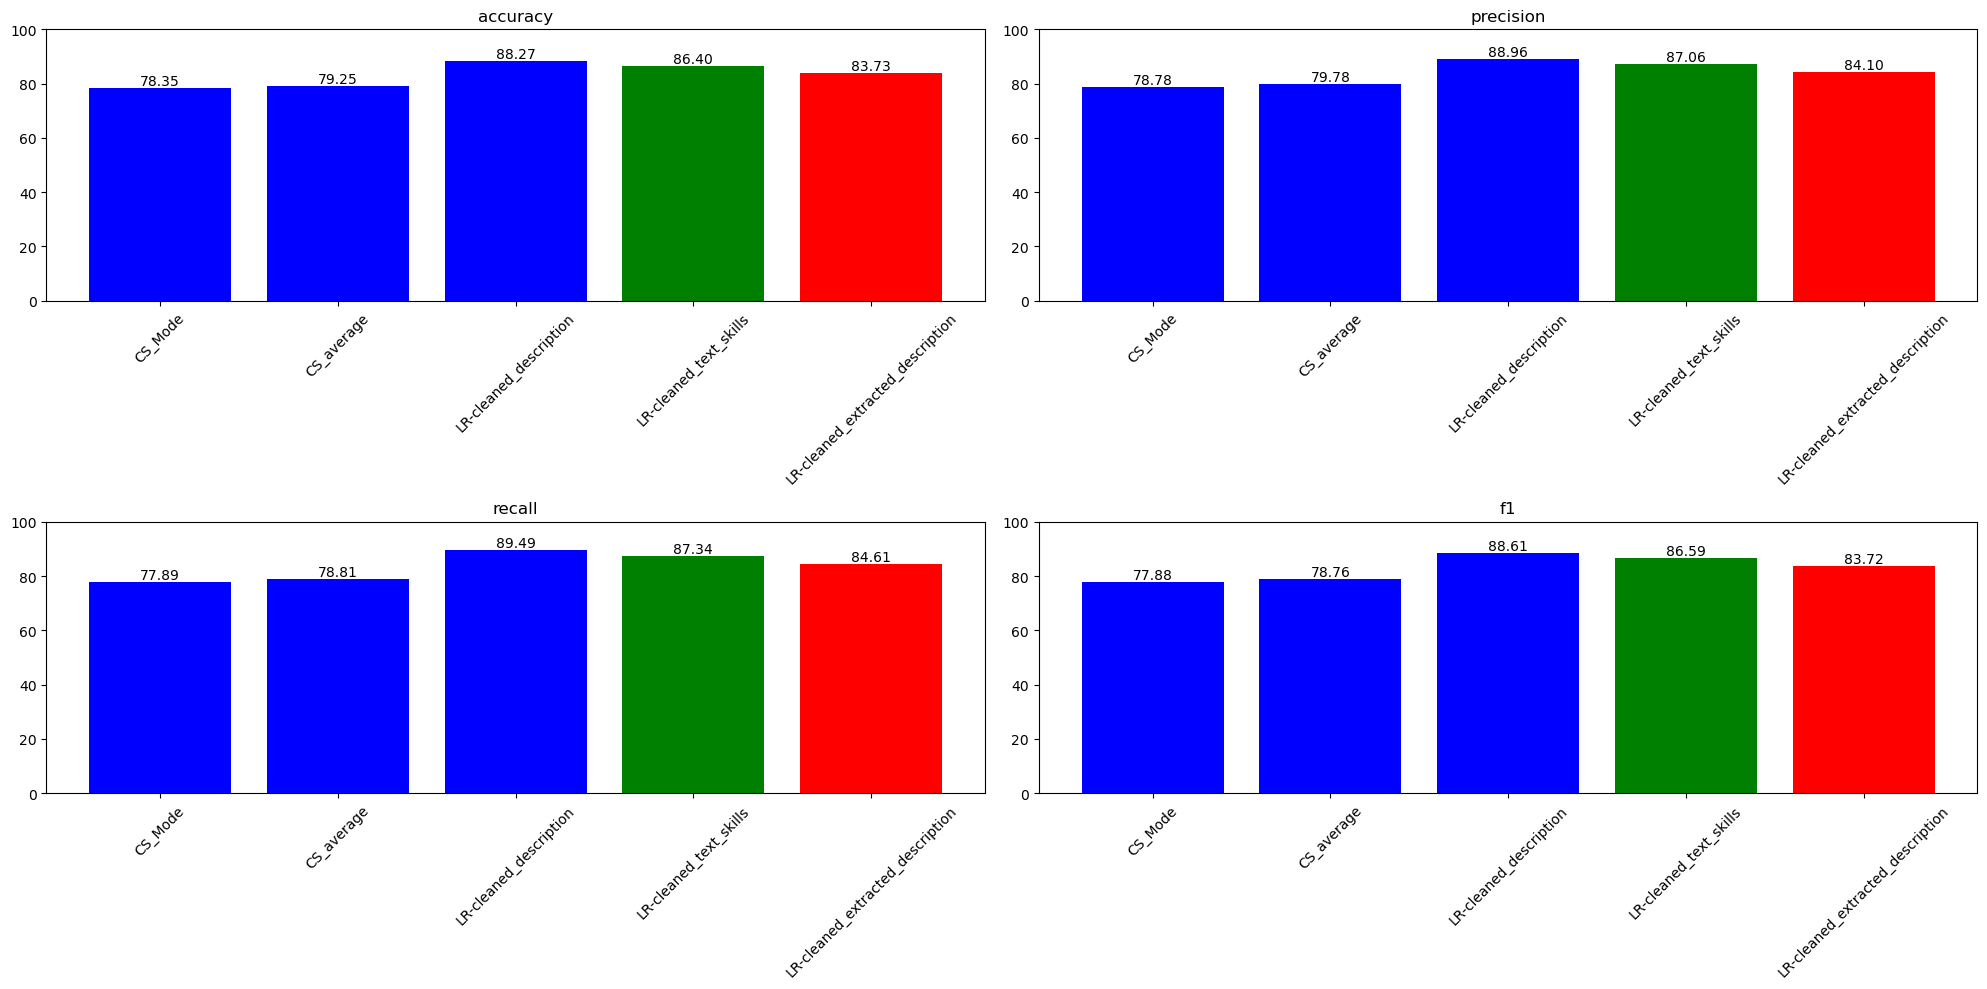

In [263]:
# Grid search tested
param_grid_tested = {
    'tfidf__min_df': [0.05, 0.1, 0.15, 0.2],
    'tfidf__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],  
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2)],

    'clf__C': [0.1,0.5, 1,2],
    'clf__penalty': ['l2','l1','elasticnet'],
}

# Define the columns for logistic regression
columns = ['cleaned_description', 'cleaned_text_skills', 'cleaned_extracted_description']
color = {1: 'blue', 2: 'green', 3: 'red'}
i = 1

for col in columns:
    print(f"Performing logistic regression on column: {col}")

    # Split the data
    df = df_jobs.copy()
    df = df.dropna(subset=[col])
    X_train, X_test, y_train, y_test = train_test_split(df[col], df['Job_Title_Searched'], test_size=0.2, random_state=42)

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(solver='liblinear')),
    ])

    # Define parameter grid for grid search
    param_grid = {
        'tfidf__min_df': [0.01, 0.02, 0.03],
        'tfidf__max_df': [0.85, 0.8, 0.9],
        'tfidf__ngram_range': [(1, 2)],
        'clf__C': [2],
        'clf__penalty': ['l2'],
    }

    # Create a GridSearchCV object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_reg_jobs = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

    # Fit the grid search to the data
    log_reg_jobs.fit(X_train, y_train)

    # Make predictions
    y_pred = log_reg_jobs.predict(X_test)

    # Evaluate the model
    metrics.run(y_test, y_pred, f'LR-{col}',color=color[i])

    # Print best parameters
    print(f'Best Parameters for column {col}: {log_reg_jobs.best_params_}')
    i = i + 1

# Plot metrics
metrics.plot()

### Model: Random Forest Classifier

This model will compute predictions using a Random forest classifier model after TF-IDF vectorization on the text to predict the job title.

Performing random forest classifer on column: cleaned_description
Best Parameters for column cleaned_description: {'rfc__max_depth': None, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}
Performing random forest classifer on column: cleaned_text_skills
Best Parameters for column cleaned_text_skills: {'rfc__max_depth': 20, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}
Performing random forest classifer on column: cleaned_extracted_description
Best Parameters for column cleaned_extracted_description: {'rfc__max_depth': None, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}


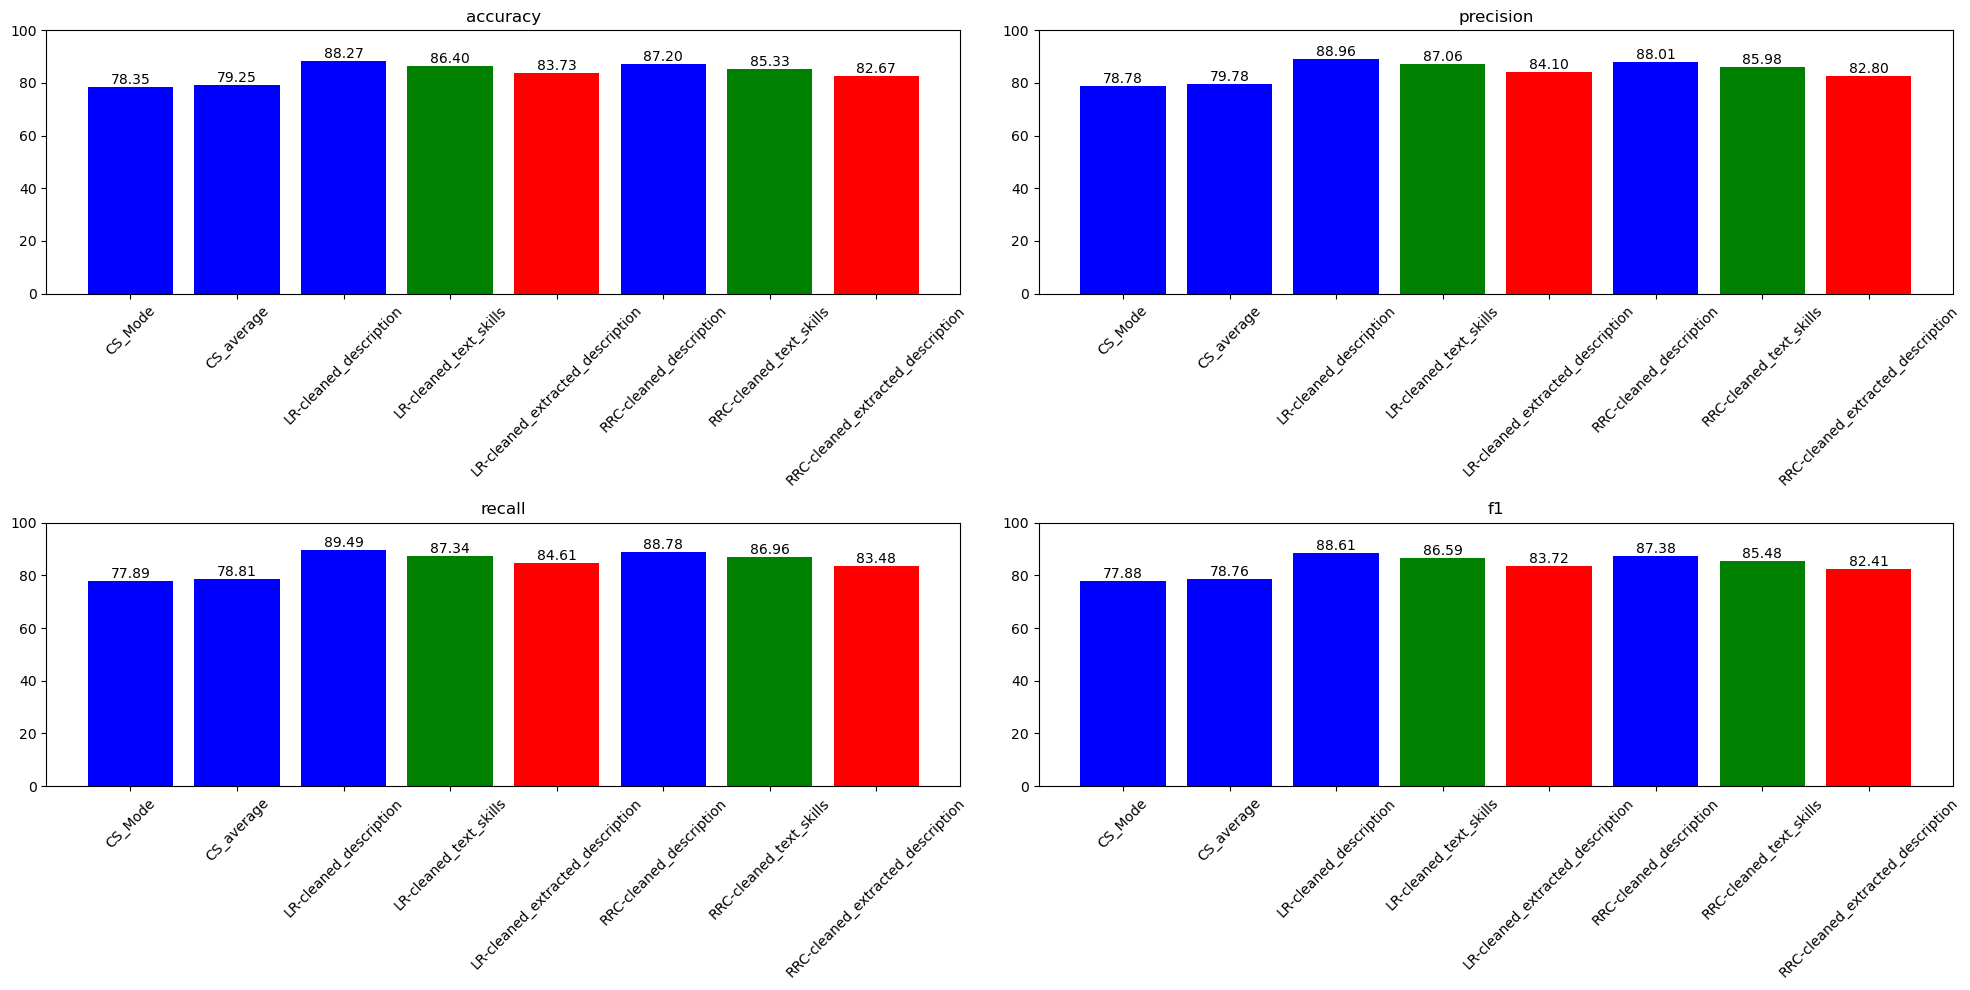

In [264]:
# Grid Search Tested
param_grid_tested = {
    'tfidf__min_df': [0.05, 0.1, 0.15, 0.2],
    'tfidf__max_df': [0.3, 0.4, 0.5, 0.6, 0.7],  
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (2,2)],

    'rfc__n_estimators': [10,20,50,100,200],
    'rfc__max_depth': [10,20,None],
    'rfc__min_samples_split': [2,5,10],
}

# Define the columns for RandomForestClassifier
columns = ['cleaned_description', 'cleaned_text_skills', 'cleaned_extracted_description']
color = {1: 'blue', 2: 'green', 3: 'red'}
i = 1

for col in columns:
    print(f"Performing random forest classifer on column: {col}")

    # Split the data
    df = df_jobs.copy()
    df = df.dropna(subset=[col])
    X_train, X_test, y_train, y_test = train_test_split(df[col], df['Job_Title_Searched'], test_size=0.2, random_state=42)

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('rfc', RandomForestClassifier(random_state=42)),
    ])

    # Define parameter grid for grid search
    param_grid = {
    'tfidf__min_df': [0.05],
    'tfidf__max_df': [0.5, 0.7],  
    'tfidf__ngram_range': [ (1, 3)],

    'rfc__n_estimators': [100],
    'rfc__max_depth': [20, None],
    'rfc__min_samples_split': [5],
}

    # Create a GridSearchCV object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rand_forest_jobs = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

    # Fit the grid search to the data
    rand_forest_jobs.fit(X_train, y_train)

    # Make predictions
    y_pred = rand_forest_jobs.predict(X_test)

    # Evaluate the model
    metrics.run(y_test, y_pred, f'RRC-{col}',color=color[i])

    # Print best parameters
    print(f'Best Parameters for column {col}: {rand_forest_jobs.best_params_}')
    i = i + 1

# Plot metrics
metrics.plot()

### Comparison:

The metrics show that the Random Forest CLassifier is the model that is working best at predicting the job title from the text of the job posting after hyperparameter optimization. 

# Model comparison - Resume to Job Matcher
In this section we will match resumes to the job postings based on their text and the skills that will be extracted from it.
### Document Term Matrix
Fitting a new count vectorizer using job postings. Job postings were used to fit the matrix and ensure constant dimensionality as the text in the job postings will be the reference for all the requirements. Unnecessary information (tokens) in the resumes that are not mentioned in any of the job postings will not appear in the matrix.

In [265]:
metrics = Metrics()

# Create document term matrix using CountVectorizer
pd.set_option('display.max_columns', None)
cv_final = CountVectorizer(ngram_range = (1,2), min_df=0.075, max_df=0.40)
cv_final.fit(df_jobs['cleaned_text_skills']) 

X_jobs = cv_final.transform(df_jobs['cleaned_text_skills'])
vectorized_jobs=X_jobs.todense()
print("JOB- Document term matrix has size:", vectorized_jobs.shape)
X_resumes = cv_final.transform(df_resume['cleaned_resume_skills'])
vectorized_resumes=X_resumes.todense()
print("CV - Document term matrix has size:", vectorized_resumes.shape)

JOB- Document term matrix has size: (1875, 900)
CV - Document term matrix has size: (513, 900)


Some small EDA will be computed to check just the most common words and their distribution.

In [266]:
term_frequencies = np.sum(vectorized_jobs, axis=0).A1

# Sort frequencies and get sorted indices
sorted_indices = np.argsort(term_frequencies)[::-1]
sorted_frequencies = term_frequencies[list(sorted_indices)]

# Generate Term IDs (1-based indexing for better readability)
term_ids = np.arange(1, len(sorted_frequencies) + 1)

# Find the maximum value in the sorted frequencies
max_term_frequency = np.max(sorted_frequencies)
print("Max term frequency is", max_term_frequency)

# Get the feature names from the count vectorizer
feature_names = cv_final.get_feature_names_out()

# Now use sorted_indices to get the top terms
top_indices = sorted_indices[:5]  # Get the indices for the top 5 terms
top_terms = feature_names[top_indices]  # Get the corresponding feature names

# Now print out the top terms with their frequencies
for term, freq in zip(top_terms, sorted_frequencies[:5]):
    print(f"Term: {term}, Frequency: {freq}")

Max term frequency is 4316
Term: databas, Frequency: 4316
Term: sale, Frequency: 3833
Term: sql, Frequency: 3772
Term: python, Frequency: 3470
Term: cloud, Frequency: 3226


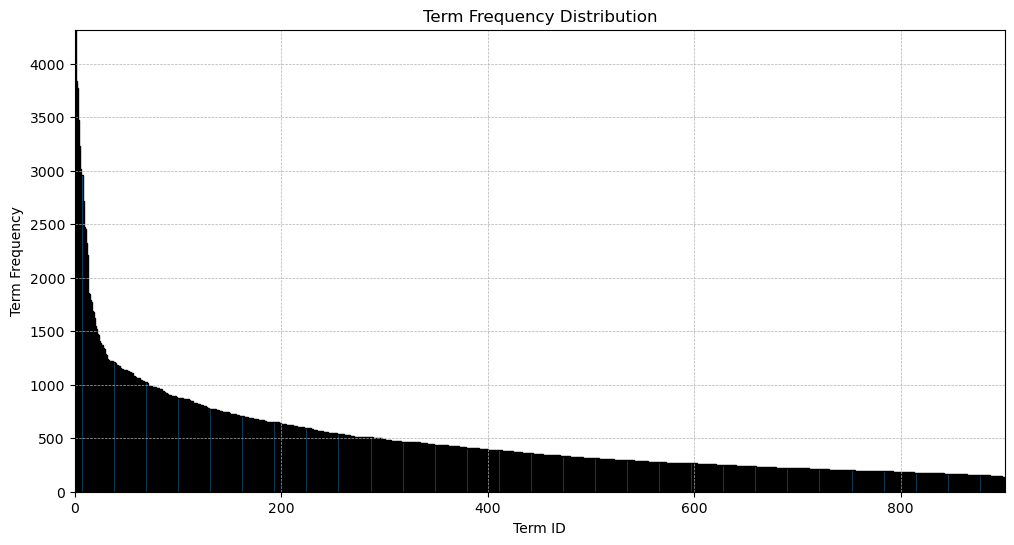

In [267]:
# Plotting with adjusted y-axis limits
plt.figure(figsize=(12, 6))
plt.bar(term_ids, sorted_frequencies, width=1.0, edgecolor='black')

# Set the y-axis and x-axis limits to start at 0 and end at the maximum
plt.ylim(0, max_term_frequency)
plt.xlim(left=0, right=len(term_ids)+1) 

# Improve the appearance
plt.title('Term Frequency Distribution')
plt.xlabel('Term ID')
plt.ylabel('Term Frequency')
plt.grid(True, which="both", ls="--", linewidth=0.5)

plt.axhline(y=0, color='black', linewidth=1)

plt.show()

In the following code blocks we will run and evaluate the different models. LDA will not be computed in this case as the results will not be relevant due to the numerous topics that will be taken into account in the resumes. For the rest the same models will be computed.

### Model: Cosine Similarity (mode match)

In [339]:
# Initialize a dictionary to store the top 10 matches for each resume
matching_dictionary = {}

# Iterate through each job oofer and find the top 10 matches
for resume_id, resume_vector in enumerate(vectorized_resumes):
    similarities = {}
    top_matches = []
    for job_id, job_vector in enumerate(vectorized_jobs_cts):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        # Sort the dictionary based on values in ascending order
        if len(similarities)<10:
            similarities[job_id]=similarity
        elif similarity>next(iter(similarities.values())):
            first_key = next(iter(similarities))
            similarities[job_id] = similarity
            del similarities[first_key]
        similarities = dict(sorted(similarities.items(), key=lambda item: item[1]))
    # top_matches = similarities[-10:][::-1]  # Get indices of top 10 matches
    matching_dictionary[resume_id] = similarities

In [343]:
# Create a DataFrame to store the results
columns = [f"Match_{i+1}" for i in range(10)]
result_df = pd.DataFrame(columns=columns)

# Iterate through each resume in df_new and extract the top 10 job titles
for resume_id, matches in matching_dictionary.items():
    job_ids = list(matches.keys())
    job_titles = df_jobs.loc[df_jobs['id'].isin(job_ids), 'Job_Title_Searched'].tolist()
    result_df.loc[resume_id] = job_titles

# Reset index of result_df
result_df.reset_index(drop=True, inplace=True)
df_resume.reset_index(drop=True, inplace=True)

# Function to find the most common element in a list
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

# Add 'Predicted_job' column based on the most common job title in each row
result_df['job_title_mode_cs'] = result_df.apply(lambda row: most_common(row), axis=1)

# Fill NA values with 'Other'
result_df['job_title_mode_cs'].fillna('Other', inplace=True)
if len(result_df) == len(df_resume):
    df_resume['job_title_mode_cs'] = result_df['job_title_mode_cs']

Metrics:

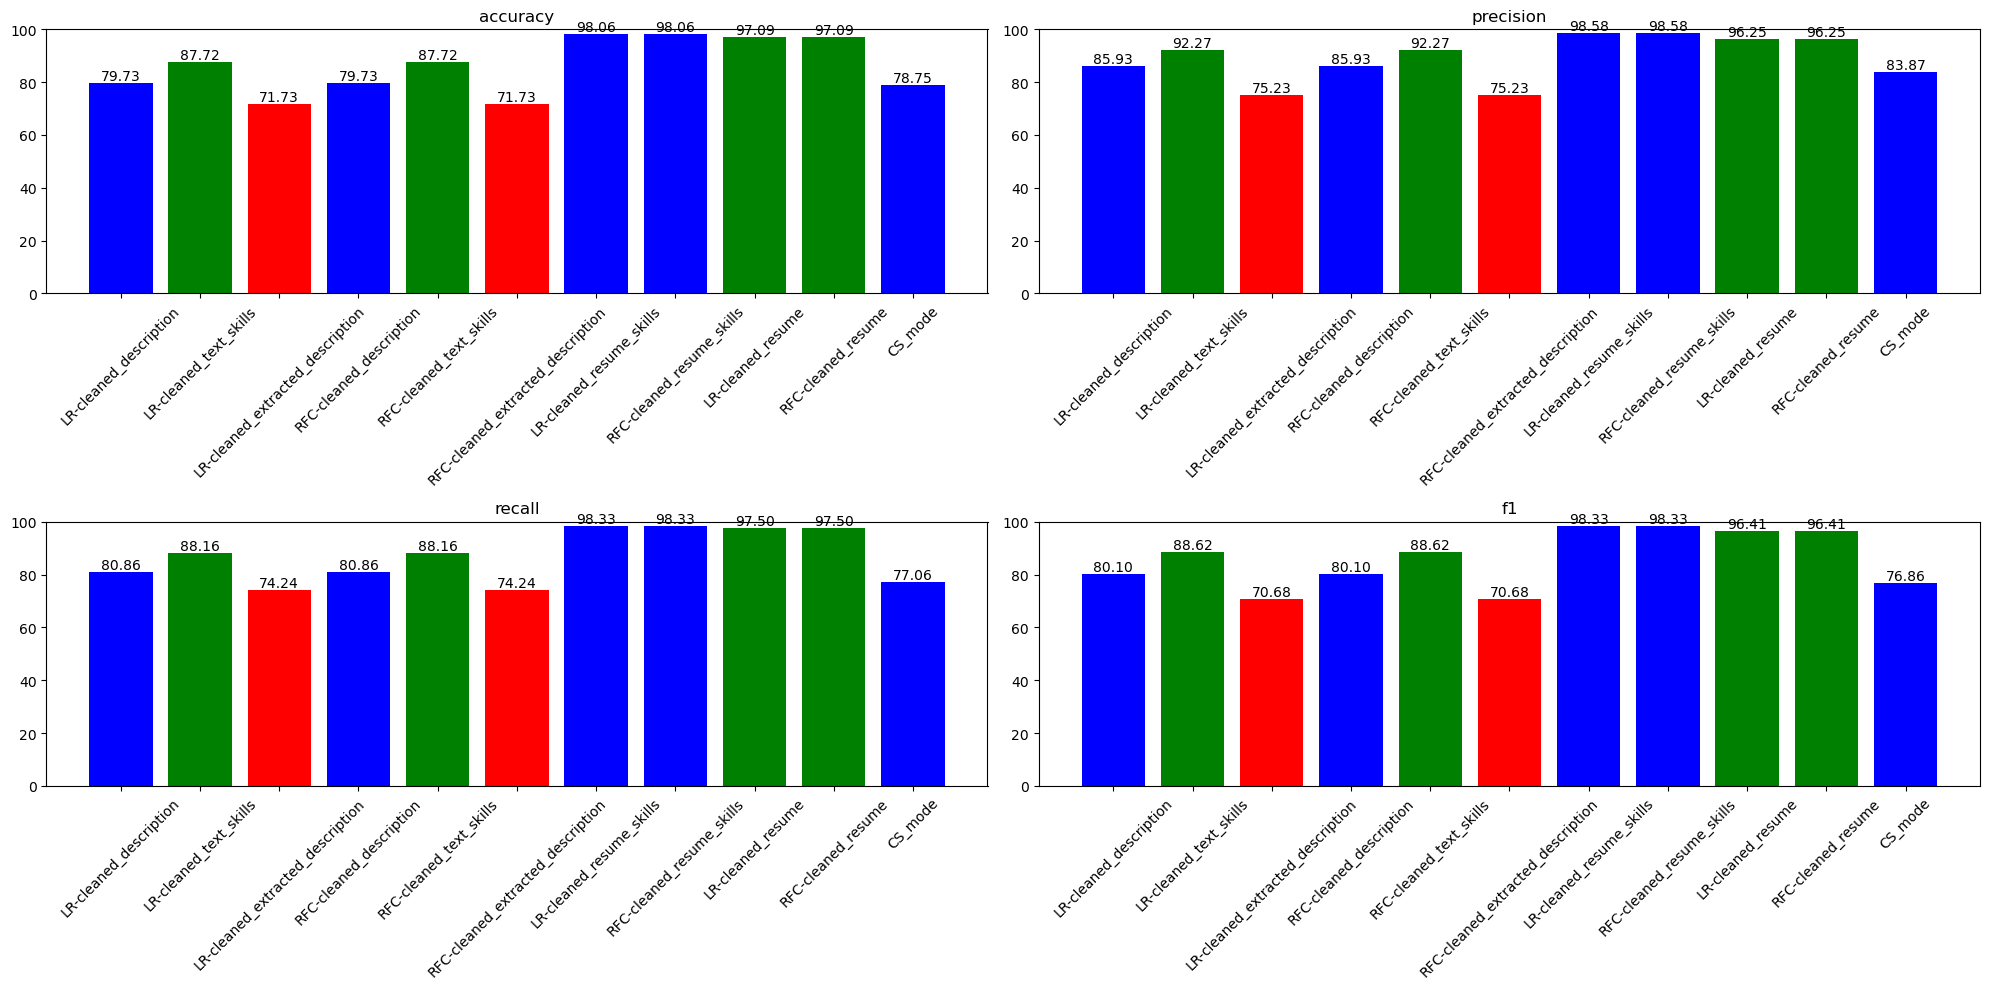

In [344]:
y_true = df_resume['Category']
y_pred = df_resume['job_title_mode_cs']
metrics.run(y_true, y_pred, 'CS_mode')
metrics.plot()

### Model: Cosine similarity (average match)

In [345]:
# Initialize dictionaries to store the similarity scores and average similarity for each resume and cluster
similarity_scores_dictionary = {}
average_similarity_dictionary = {}

# Iterate through each resume and find the similarity scores for each cluster
for resume_id, resume_vector in enumerate(vectorized_resumes):
    cluster_similarities = {cluster: [] for cluster in df_jobs['Job_Title_Searched'].unique()}
    
    for job_id, job_vector in enumerate(vectorized_jobs_cts):
        similarity = float(cosine_similarity(resume_vector, job_vector))
        cluster = df_jobs.loc[df_jobs['id'] == job_id, 'Job_Title_Searched'].iloc[0]
        cluster_similarities[cluster].append(similarity)
    
    # Store the similarity scores in the dictionary
    similarity_scores_dictionary[resume_id] = cluster_similarities

    # Compute the average similarity for each cluster
    average_similarity = {f"{cluster}": np.mean(similarities) for cluster, similarities in cluster_similarities.items()}
    
    # Store the results in the dictionary
    average_similarity_dictionary[resume_id] = average_similarity
# Create DataFrames for average similarity and similarity scores
average_similarity_df = pd.DataFrame(average_similarity_dictionary).T


513 513


,index,Category,Resume,cleaned_resume,Experience,Skills,Education,id,hard_skills,soft_skills,cleaned_resume_skills,log_reg_job,random_forest_job,job_hard_skills,job_soft_skills,job_title_mode_cs,job_title_avg_cs
0,0,Data Science,Skills * Programming Languages: Python (pandas...,skill program languag python panda numpi scipi...,javascript exprience months jquery exprience ...,skills programming languages python pandas num...,data science assurance associate data science...,0,python numpy matplotlib sql java javascript jq...,,skill program languag python panda numpi scipi...,Python Developer,Python Developer,"[[machine, learning, developer, angular, data,...","[[analytical, collaboration, collaborate, prob...",Data Science,Python Developer
1,1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...,educ detail may may b e uit rgpv data scientis...,python exprience less year months statsmodels...,NaN,may may b e uit rgpv data scientist data scie...,1,python aws machine learning keras machine lear...,,educ detail may may b e uit rgpv data scientis...,Data Science,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr...",Data Science,Data Science
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learn control system design...,data analysis exprience less year months exce...,areas interest deep learning control system de...,january b tech electrical electronics enginee...,2,deep learning design programming python matlab...,,area interest deep learn control system design...,Python Developer,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr...",Python Developer,Python Developer
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,linear programming exprience months retail ex...,skills r python sap hana tableau sap hana sql ...,january january pgdm business analytics great...,3,python tableau sql sql c linear programming da...,,skill r python sap hana tableau sap hana sql s...,ETL Developer,ETL Developer,"[[warehouse, build, ssis, metadata, science, a...","[[problem, organizational, sales, analytical, ...",Database,ETL Developer
4,4,Data Science,"Education Details \n MCA YMCAUST, Faridabad...",educ detail mca ymcaust faridabad haryana data...,data structure exprience less year months c e...,NaN,mca ymcaust faridabad haryana data science in...,4,data analysis python java database management,,educ detail mca ymcaust faridabad haryana data...,Database,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr...",Python Developer,Python Developer


In [ ]:
# Add columns to the existing DataFrame
df_result = pd.concat([df_resume, average_similarity_df], axis=1)

# Add a column for the predicted cluster based on the highest average similarity
df_result['job_title_avg_cs'] = df_result.loc[:, average_similarity_df.columns].idxmax(axis=1)

# Fill NA values with 'Other'
df_result['job_title_avg_cs'].fillna('Other', inplace=True)
# Reset index of result_df
result_df.reset_index(drop=True, inplace=True)
df_resume.reset_index(drop=True, inplace=True)
print(len(result_df), len(df_resume))
if len(result_df) == len(df_resume):
    df_resume['job_title_avg_cs'] = df_result['job_title_avg_cs']

# Display or use df_result as needed
df_resume.head()


Metrics:

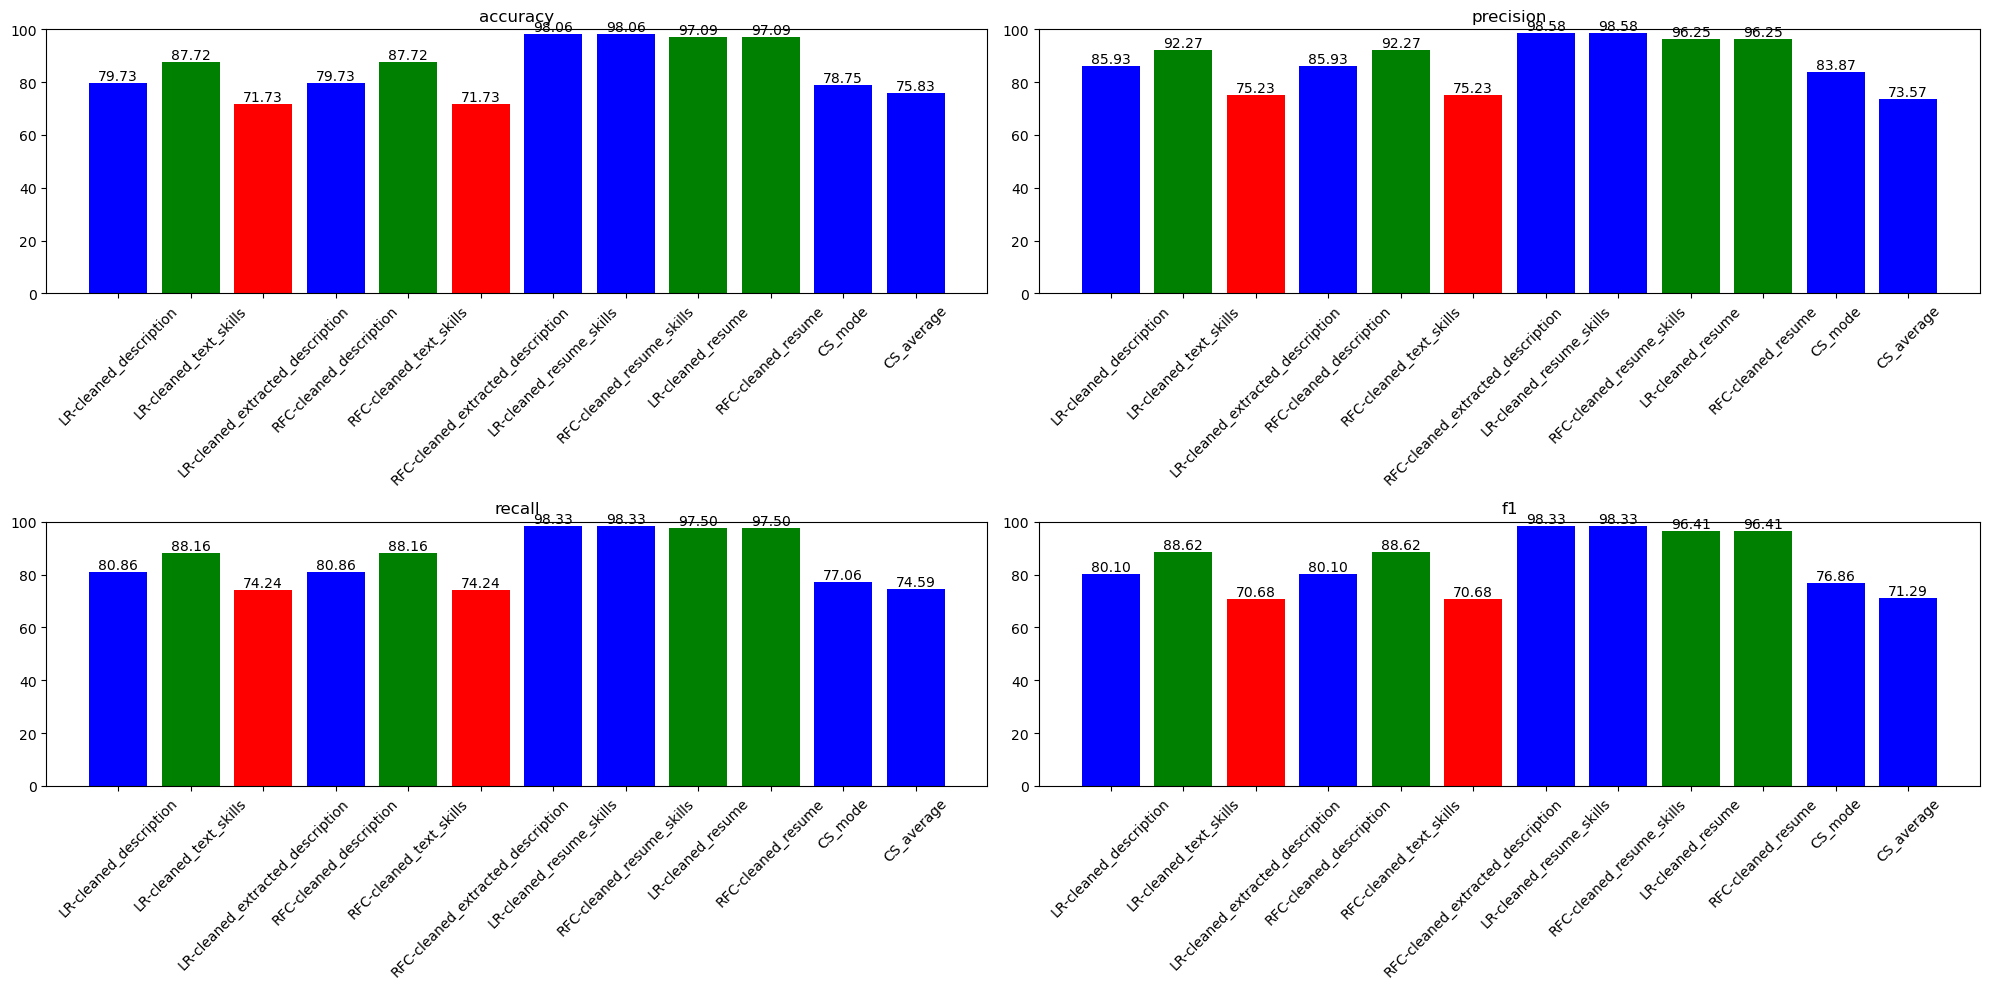

In [346]:
y_true = df_resume["Category"]
y_pred = df_resume["job_title_avg_cs"]
metrics.run(y_true, y_pred, 'CS_average')
metrics.plot()

### Model: Logistic Regression match

Performing logistic regression on column: cleaned_description
Best Parameters for column cleaned_description: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.02, 'tfidf__ngram_range': (1, 2)}
Performing logistic regression on column: cleaned_text_skills
Best Parameters for column cleaned_text_skills: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.8, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}
Performing logistic regression on column: cleaned_extracted_description
Best Parameters for column cleaned_extracted_description: {'clf__C': 2, 'clf__penalty': 'l2', 'tfidf__max_df': 0.85, 'tfidf__min_df': 0.01, 'tfidf__ngram_range': (1, 2)}


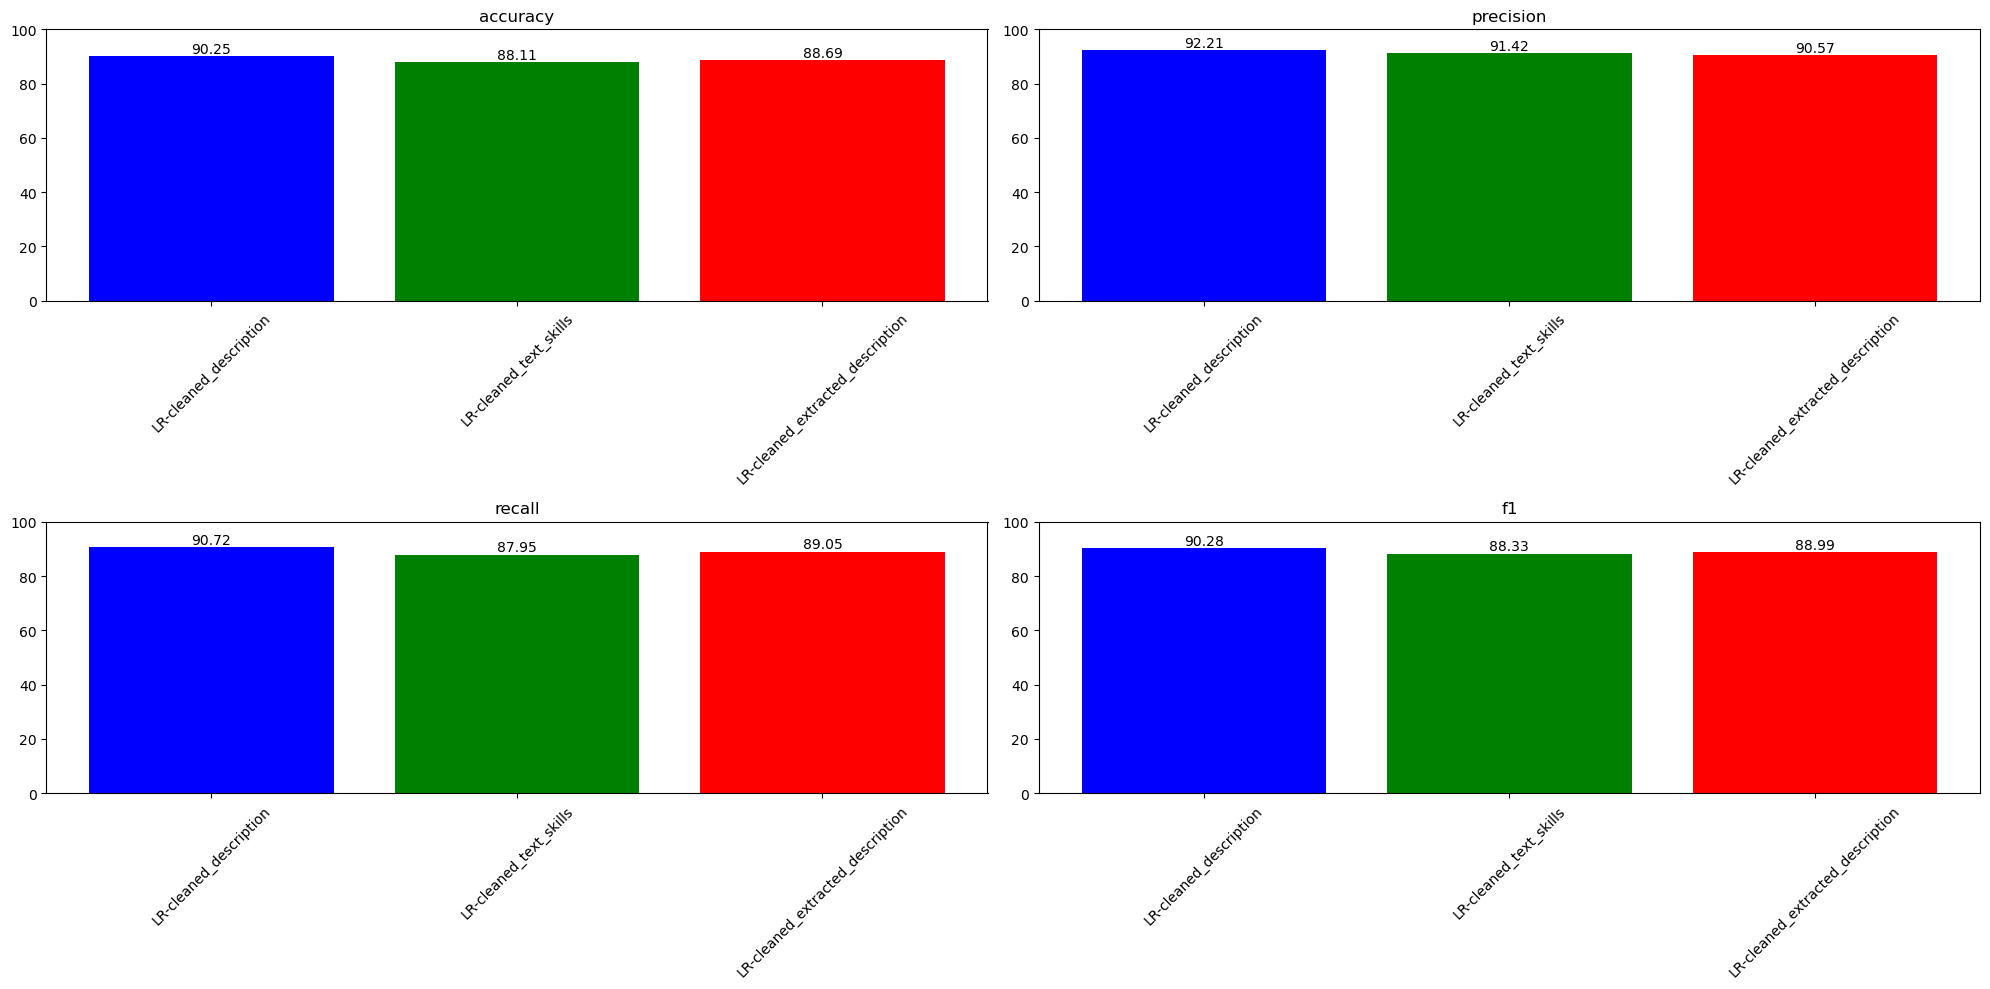

In [273]:
# Define the columns for logistic regression
columns = ['cleaned_description', 'cleaned_text_skills', 'cleaned_extracted_description']
color = {1: 'blue', 2: 'green', 3: 'red'}

i = 1
score = 0
for col in columns:
    print(f"Performing logistic regression on column: {col}")

    # Split the data
    df = df_jobs.copy()
    df = df.dropna(subset=[col])
    X_train, X_test, y_train, y_test = train_test_split(df[col], df['Job_Title_Searched'], test_size=0.2, random_state=42)

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('clf', LogisticRegression(solver='liblinear')),
    ])

    # Define parameter grid for grid search
    param_grid = {
        'tfidf__min_df': [0.01, 0.02, 0.03],
        'tfidf__max_df': [0.85, 0.8, 0.9],
        'tfidf__ngram_range': [(1, 2)],
        'clf__C': [2],
        'clf__penalty': ['l2'],
    }

    # Create a GridSearchCV object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    log_reg_match = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

    # Fit the grid search to the data
    log_reg_match.fit(X_train, y_train)

    # Make predictions
    y_pred = log_reg_match.predict(df_resume['cleaned_resume_skills'])
    if log_reg_match.best_score_ > score:
        score = log_reg_match.best_score_
        log_reg_best = log_reg_match.best_estimator_
    metrics.run(df_resume['Category'], y_pred, f'LR-{col}',color=color[i])

    # Print best parameters
    print(f'Best Parameters for column {col}: {log_reg_match.best_params_}')
    i = i + 1
df_resume['log_reg_job'] = log_reg_best.predict(df_resume['cleaned_resume_skills'])
# Plot metrics
metrics.plot()

### Model: Random Forest Classifier match

Performing random forest classifer on column: cleaned_description
Best Parameters for column cleaned_description: {'rfc__max_depth': None, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.7, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}
Performing random forest classifer on column: cleaned_text_skills
Best Parameters for column cleaned_text_skills: {'rfc__max_depth': 20, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}
Performing random forest classifer on column: cleaned_extracted_description
Best Parameters for column cleaned_extracted_description: {'rfc__max_depth': None, 'rfc__min_samples_split': 5, 'rfc__n_estimators': 100, 'tfidf__max_df': 0.5, 'tfidf__min_df': 0.05, 'tfidf__ngram_range': (1, 3)}


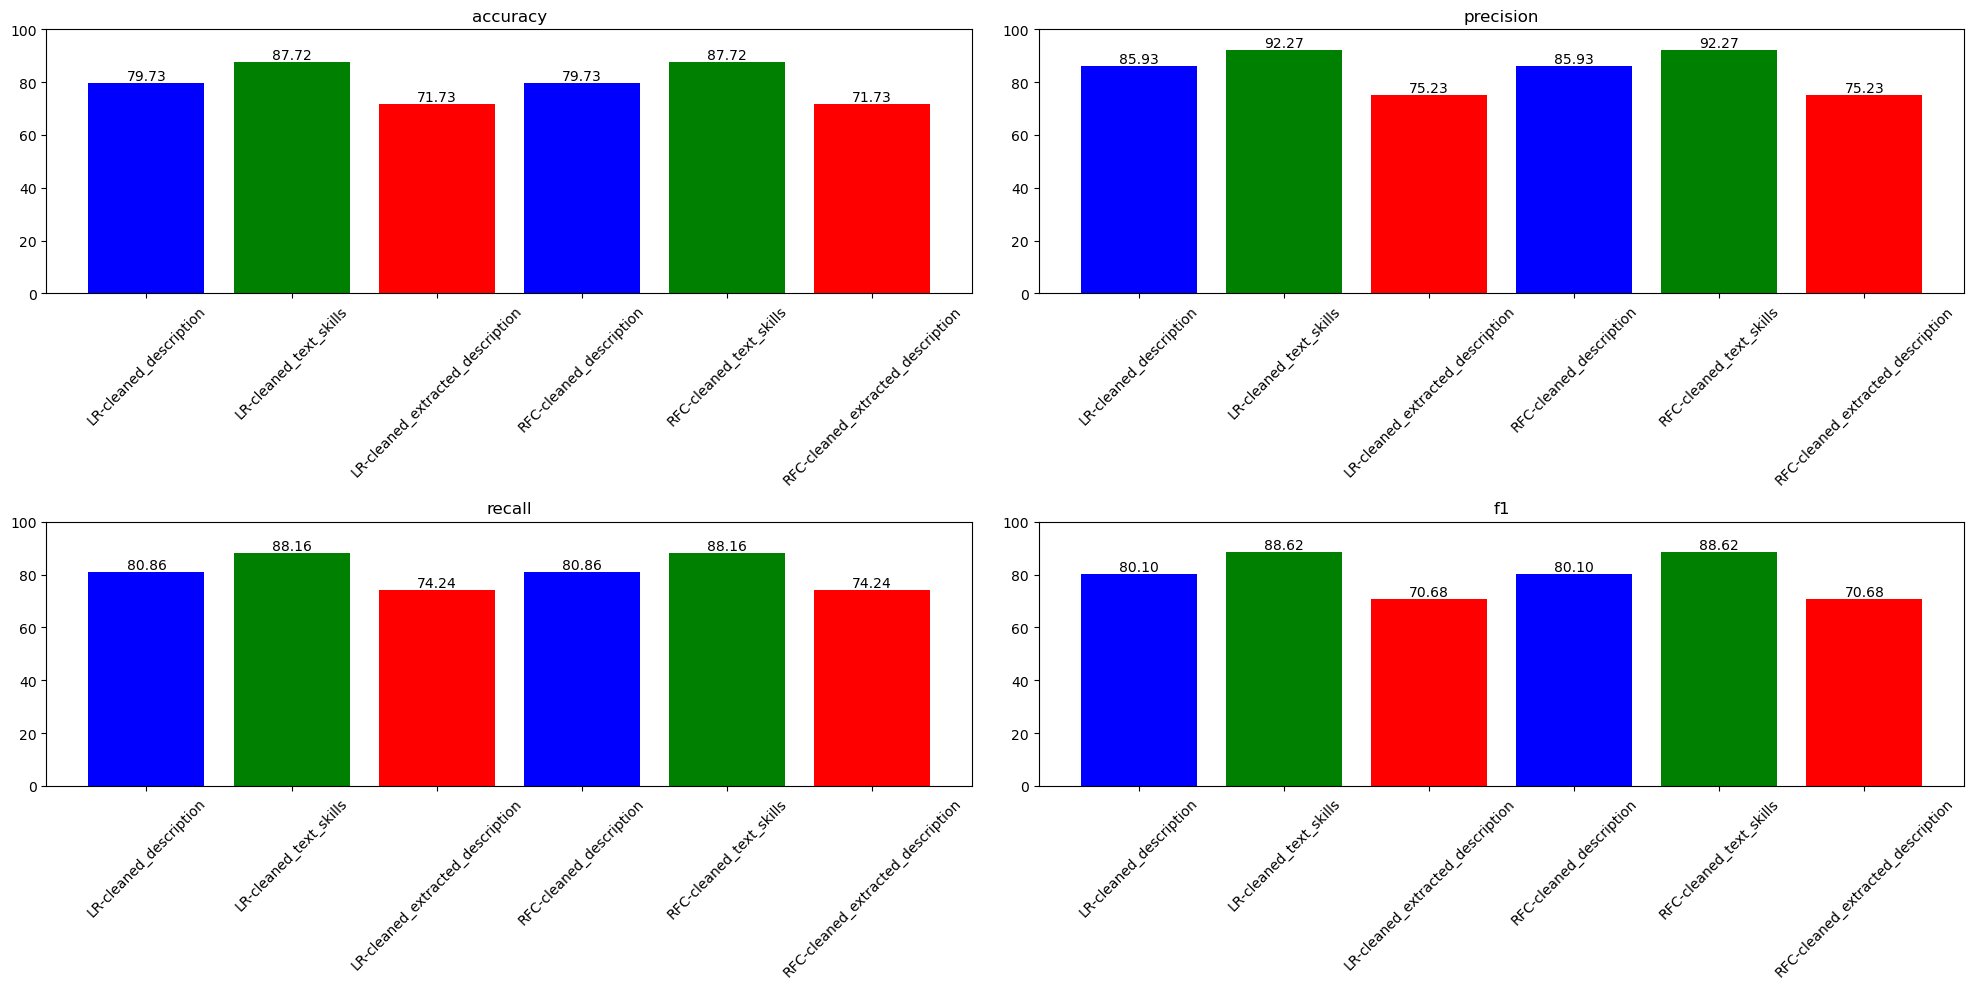

In [274]:
# Define the columns for RandomForestClassifier
columns = ['cleaned_description', 'cleaned_text_skills', 'cleaned_extracted_description']
color = {1: 'blue', 2: 'green', 3: 'red'}
i = 1
score = 0
for col in columns:
    print(f"Performing random forest classifer on column: {col}")

    # Split the data
    df = df_jobs.copy()
    df = df.dropna(subset=[col])
    X_train, X_test, y_train, y_test = train_test_split(df[col], df['Job_Title_Searched'], test_size=0.2, random_state=42)

    # Define the pipeline
    pipeline = Pipeline([
        ('tfidf', TfidfVectorizer()),
        ('rfc', RandomForestClassifier(random_state=42)),
    ])

    # Define parameter grid for grid search
    param_grid = {
    'tfidf__min_df': [0.05],
    'tfidf__max_df': [0.5, 0.7],  
    'tfidf__ngram_range': [ (1, 3)],

    'rfc__n_estimators': [100],
    'rfc__max_depth': [20, None],
    'rfc__min_samples_split': [5],
}

    # Create a GridSearchCV object
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    rand_forest_match = GridSearchCV(pipeline, param_grid, cv=cv, n_jobs=-1)

    # Fit the grid search to the data
    rand_forest_match.fit(X_train, y_train)

     # Make predictions
    y_pred = rand_forest_match.predict(df_resume['cleaned_resume_skills'])
    if rand_forest_match.best_score_ > score:
        score = rand_forest_match.best_score_
        random_forest_best = rand_forest_match.best_estimator_
    metrics.run(df_resume['Category'], y_pred, f'LR-{col}',color=color[i])
    metrics.run(df_resume['Category'], y_pred, f'RFC-{col}',color=color[i])

    # Print best parameters
    print(f'Best Parameters for column {col}: {rand_forest_match.best_params_}')
    i = i + 1
df_resume['random_forest_job'] = random_forest_best.predict(df_resume['cleaned_resume_skills'])
# Plot metrics
metrics.plot()

## Required Skills per job

In this final section we will compute all the mostly required skills per job and match them with the resumes with a dynamic instrument, so that applicants will know which are the most important skills to focus on.

In [275]:
df_jobs['Job_Title_Searched'].unique()

array(['Data Science', 'Mechanical Engineer', 'Sales', 'Java Developer',
       'Business Analyst', 'Operations Manager', 'Python Developer',
       'DevOps Engineer', 'Network Security Engineer', 'Database',
       'Blockchain', 'ETL Developer'], dtype=object)

In [276]:
df_jobs

,Job_Title_Searched,Description,cleaned_description,cleaned_extracted_description,description_length,id,hard_skills,soft_skills,cleaned_text_skills,cleaned_extracted_skills,job_title_mode_cs,job_title_avg_cs
0,Data Science,About the California Policy Lab\nThe Californi...,california polici lab california polici lab tr...,california polici lab california polici lab tr...,565.0,0,data analyst cleaning statistical data analyst...,communication,california polici lab california polici lab tr...,california policy lab california policy lab tr...,Data Science,Data Science
1,Data Science,Job Description\nThe Research Data Scientist p...,job descript research data scientist particip ...,job descript research data scientist particip ...,2553.0,1,data mining statistics machine learning algori...,communication,job descript research data scientist particip ...,job description research data scientist partic...,Data Science,Data Science
2,Data Science,Expatiate Communications is a boutique managem...,expati communic boutiqu manag consult firm unm...,expati communic boutiqu manag consult firm unm...,2153.0,2,algorithms algorithms ai develop algorithms ai...,communication organizational prioritize manage...,expati communic boutiqu manag consult firm unm...,expatiate communications boutique management c...,Data Science,Data Science
3,Data Science,"Los Angeles, California\nFinance\nNetflix is t...",los angel california financ netflix world lead...,los angel california financ netflix world lead...,2311.0,3,analytics programming quantitative analysis mo...,strategic strategic communication,los angel california financ netflix world lead...,los angeles california finance netflix world l...,Business Analyst,Business Analyst
4,Data Science,POSITION SUMMARY\nTapBlaze is looking for an a...,posit summari tapblaz look ambiti innov produc...,posit summari tapblaz look ambiti innov produc...,2821.0,4,statistical dashboards dashboards statistical ...,,posit summari tapblaz look ambiti innov produc...,position summary tapblaze looking ambitious in...,Data Science,Data Science
...,...,...,...,...,...,...,...,...,...,...,...,...
1870,ETL Developer,KeyLogic is actively seeking a Data Architect ...,keylog activ seek data architect design develo...,keylog activ seek data architect design develo...,2712.0,1870,pipelines aws cloud aws cloud data data cloud ...,high quality solutions keylogic,keylog activ seek data architect design develo...,keylogic actively seeking data architect desig...,DevOps Engineer,DevOps Engineer
1871,ETL Developer,About the Opportunity\nThis job description is...,opportun job descript intend describ general n...,opportun job descript intend describ general n...,3950.0,1871,computer science java python javascript databa...,communication presentation motivated organizat...,opportun job descript intend describ general n...,opportunity job description intended describe ...,ETL Developer,Python Developer
1872,ETL Developer,SS&C is a global provider of investment and fi...,ss c global provid invest financi servic softw...,ss c global provid invest financi servic softw...,1092.0,1872,c etl r machine learning snowflake programming...,creativity,ss c global provid invest financi servic softw...,ss c global provider investment financial serv...,ETL Developer,ETL Developer
1873,ETL Developer,Job Summary\nThe Kempner Institute for the Stu...,job summari kempner institut studi natur artif...,job summari kempner institut studi natur artif...,3974.0,1873,artificial intelligence artificial contexts ma...,communication problem solving collaborative pr...,job summari kempner institut studi natur artif...,job summary kempner institute study natural ar...,Data Science,Data Science


### Finding most relevant skills

In [277]:
df_resume

,index,Category,Resume,cleaned_resume,Experience,Skills,Education,id,hard_skills,soft_skills,cleaned_resume_skills,log_reg_job,random_forest_job
0,0,Data Science,Skills * Programming Languages: Python (pandas...,skill program languag python panda numpi scipi...,javascript exprience months jquery exprience ...,skills programming languages python pandas num...,data science assurance associate data science...,0,python numpy matplotlib sql java javascript jq...,,skill program languag python panda numpi scipi...,Python Developer,Python Developer
1,1,Data Science,Education Details \nMay 2013 to May 2017 B.E ...,educ detail may may b e uit rgpv data scientis...,python exprience less year months statsmodels...,NaN,may may b e uit rgpv data scientist data scie...,1,python aws machine learning keras machine lear...,,educ detail may may b e uit rgpv data scientis...,Data Science,Data Science
2,2,Data Science,"Areas of Interest Deep Learning, Control Syste...",area interest deep learn control system design...,data analysis exprience less year months exce...,areas interest deep learning control system de...,january b tech electrical electronics enginee...,2,deep learning design programming python matlab...,,area interest deep learn control system design...,Python Developer,Data Science
3,3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skill r python sap hana tableau sap hana sql s...,linear programming exprience months retail ex...,skills r python sap hana tableau sap hana sql ...,january january pgdm business analytics great...,3,python tableau sql sql c linear programming da...,,skill r python sap hana tableau sap hana sql s...,ETL Developer,ETL Developer
4,4,Data Science,"Education Details \n MCA YMCAUST, Faridabad...",educ detail mca ymcaust faridabad haryana data...,data structure exprience less year months c e...,NaN,mca ymcaust faridabad haryana data science in...,4,data analysis python java database management,,educ detail mca ymcaust faridabad haryana data...,Database,Data Science
...,...,...,...,...,...,...,...,...,...,...,...,...,...
508,887,Blockchain,Hobbies â¢ Playing Chess â¢ Solving Rubik's ...,hobbi play chess solv rubik cube watch seri la...,blockchain exprience months smart contracts e...,hobbies playing chess solving rubik cube watch...,january january bachelor degree information t...,508,blockchain developer corpcloud blockchain smar...,,hobbi play chess solv rubik cube watch seri la...,Blockchain,Blockchain
509,888,Blockchain,Skills Strong CS fundamentals and problem solv...,skill strong cs fundament problem solv ethereu...,mongodb exprience months contracts exprience ...,skills strong cs fundamentals problem solving ...,january tech computer engineering jaipur raja...,509,smart contracts aws docker microservices block...,problem solving solidity problem solving,skill strong cs fundament problem solv ethereu...,Blockchain,Blockchain
510,889,Blockchain,"KEY SKILLS: Programing languages: C, C++, Pyth...",key skill program languag c c python apex visu...,ap exprience months apex exprience months c e...,key skills programing languages c c python ape...,january b e computer engineering pune maharas...,510,c c python database mysql blockchain html css ...,,key skill program languag c c python apex visu...,Blockchain,Blockchain
511,890,Blockchain,"SOFTWARE SKILLS: Languages: C, C++ & java Oper...",softwar skill languag c c java oper system win...,java exprience months css exprience months ht...,software skills languages c c java operating s...,high school diploma government women ranchi j...,511,c c java xp ubuntu oracle sql database sql scr...,,softwar skill languag c c java oper system win...,Blockchain,Java Developer


In [278]:
# df_jobs = df_jobs[~df_jobs['Job_Title_Searched'].isna()]
# Initialize dictionaries to store the top 10 hard and soft skills for each cluster
top_hard_skills_dict = {}
top_soft_skills_dict = {}

# Iterate through each cluster
for cluster in df_jobs['Job_Title_Searched'].unique():
    # Filter data for the current cluster
    cluster_data = df_jobs[df_jobs['Job_Title_Searched'] == cluster]
    # display(cluster_data)
    # Create a TF-IDF vectorizer for hard skills
    vectorizer_hard = TfidfVectorizer(stop_words='english', min_df=0.07)
    tfidf_matrix_hard = vectorizer_hard.fit_transform(cluster_data['hard_skills'])
    feature_names_hard = np.array(vectorizer_hard.get_feature_names_out())
    total_tfidf_scores_hard = np.sum(tfidf_matrix_hard, axis=0)
    top_indices_hard = total_tfidf_scores_hard.argsort()[0, -20:][::-1]
    top_hard_skills = feature_names_hard[top_indices_hard]
    top_hard_skills_dict[cluster] = top_hard_skills

    # Create a TF-IDF vectorizer for soft skills
    vectorizer_soft = TfidfVectorizer(stop_words='english', min_df=0.05)
    tfidf_matrix_soft = vectorizer_soft.fit_transform(cluster_data['soft_skills'])
    feature_names_soft = np.array(vectorizer_soft.get_feature_names_out())
    total_tfidf_scores_soft = np.sum(tfidf_matrix_soft, axis=0)
    top_indices_soft = total_tfidf_scores_soft.argsort()[0, -20:][::-1]
    top_soft_skills = feature_names_soft[top_indices_soft]
    top_soft_skills_dict[cluster] = top_soft_skills

# Create new columns 'job_hard_skills' and 'job_soft_skills' in df_jobs
df_resume['job_hard_skills'] = df_resume['random_forest_job'].map(top_hard_skills_dict)
df_resume['job_soft_skills'] = df_resume['random_forest_job'].map(top_soft_skills_dict)

# Display df_jobs with the new columns
display(df_resume[['random_forest_job', 'job_hard_skills', 'job_soft_skills']])


,random_forest_job,job_hard_skills,job_soft_skills
0,Python Developer,"[[machine, learning, developer, angular, data,...","[[analytical, collaboration, collaborate, prob..."
1,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr..."
2,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr..."
3,ETL Developer,"[[warehouse, build, ssis, metadata, science, a...","[[problem, organizational, sales, analytical, ..."
4,Data Science,"[[visualization, sas, dashboards, excel, codin...","[[critical, thinking, sales, presentations, pr..."
...,...,...,...
508,Blockchain,"[[sql, statistics, big, ideas, data, aws, pyth...","[[problem, solving, interpersonal, collaborati..."
509,Blockchain,"[[sql, statistics, big, ideas, data, aws, pyth...","[[problem, solving, interpersonal, collaborati..."
510,Blockchain,"[[sql, statistics, big, ideas, data, aws, pyth...","[[problem, solving, interpersonal, collaborati..."
511,Java Developer,"[[build, code, oracle, end, aws, js, ui, debug...","[[solving, problem, analytical, interpersonal,..."


In [279]:
job_titles = df_jobs['Job_Title_Searched'].unique()
hard_skills = {}
job_titles = df_jobs['Job_Title_Searched'].unique()
for job_title in job_titles:
    hard_skills[job_title] = df_resume.loc[df_resume['random_forest_job'] == job_title, 'job_hard_skills'].values[0].tolist()


In [375]:
import ipywidgets as widgets
from IPython.display import display, HTML

# Function to update displayed skills based on selected job title
def update_skills(change):
    job_title = change.new
    hard_skills = df_resume.loc[df_resume['random_forest_job'] == job_title, 'job_hard_skills'].values[0].tolist()
    soft_skills = df_resume.loc[df_resume['random_forest_job'] == job_title, 'job_soft_skills'].values[0].tolist()
    hard_skills_output.value = '\n'.join(map(str, hard_skills))  # Convert each element to string
    soft_skills_output.value = '\n'.join(map(str, soft_skills))  # Convert each element to string

# Dropdown widget for selecting job titles
job_titles_dropdown = widgets.Dropdown(options=df_resume['random_forest_job'].unique(), description='Select Job Title:',
                                       style={'description_width': 'initial', 'width': '350px'},
                                       layout=widgets.Layout(margin='0 0 20px 0'))

job_titles_dropdown.observe(update_skills, names='value')

# Output widgets to display the selected job title and its corresponding hard and soft skills
hard_skills_output = widgets.Textarea(description='Hard Skills:', disabled=True, layout=widgets.Layout(width='400px', height='150px'))
soft_skills_output = widgets.Textarea(description='Soft Skills:', disabled=True, layout=widgets.Layout(width='400px', height='150px'))

# Style for the output widgets
output_style = {'description_width': 'initial', 'width': '400px', 'height': '150px'}

# Display widgets with custom styling
display(widgets.VBox([
    widgets.HTML(value="<h1 style='color: #008299; font-family: Georgia, sans-serif;'>Most required Skills</h1>"),
    widgets.HBox([job_titles_dropdown]),
    widgets.HTML(value="<hr style='border: 1px solid #008299;'>"),
    widgets.HBox([
        widgets.VBox([
            widgets.HTML(value="<h2 style='color: #008299; font-family: Georgia, sans-serif;'>Hard Skills</h2>"),
            hard_skills_output
        ], layout=widgets.Layout(margin='0 20px 0 0')),
        widgets.VBox([
            widgets.HTML(value="<h2 style='color: #008299; font-family: Georgia, sans-serif;'>Soft Skills</h2>"),
            soft_skills_output
        ], layout=widgets.Layout(margin='0 0 0 20px'))
    ])
]))


## BSE Resume Matching

In [85]:
! pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 5.8 MB/s eta 0:00:00a 0:00:01
DEPRECATION: textract 1.6.5 has a non-standard dependency specifier extract-msg<=0.29.*. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of textract or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063


### Extracting text and Parsing the CV

In [214]:
from PyPDF2 import PdfReader 
import io

In [376]:
def extract_education(resume_text):
    education_section = re.search(r'EDUCATION(.*?)PROFESSIONAL EXPERIENCE', resume_text, re.DOTALL)
    if education_section:
        return education_section.group(1).strip()

def extract_professional_experience(resume_text):
    experience_section = re.search(r'PROFESSIONAL EXPERIENCE(.*?)LANGUAGES & TECHNICAL SKILLS', resume_text, re.DOTALL)
    if experience_section:
        return experience_section.group(1).strip()

def extract_languages_technical_skills(resume_text):
    skills_section = re.search(r'LANGUAGES & TECHNICAL SKILLS(.*?)ADDITIONAL INFORMATION', resume_text, re.DOTALL)
    if skills_section:
        return skills_section.group(1).strip()

def extract_additional_information(resume_text):
    additional_info_section = re.search(r'ADDITIONAL INFORMATION(.*?)$', resume_text, re.DOTALL)
    if additional_info_section:
        return additional_info_section.group(1).strip()

def extract_skills_new(text):
    doc = nlp1(text)
    hard_skills = []
    soft_skills = []
    for ent in doc.ents:
        if (ent.label_ == 'HARD_SKILL') or (ent.label_ == 'HARD SKILL'):
            hard_skills.append(ent.text)
        elif (ent.label_ == 'SOFT_SKILL') or (ent.label_ == 'SOFT SKILL'):
            soft_skills.append(ent.text)
    skills = hard_skills + soft_skills
    return skills

def predict_job(parsed_cv):
    # # Convert parsed CV to text
    # cv_text = ""
    # for section, content in parsed_cv.items():
    #     cv_text += f"<strong>{section}:</strong><br>{content}<br>"
    # Predict using the trained model
    predicted_job = random_forest_best.predict([parsed_cv])
    return predicted_job[0]

def parse_resume(resume_text):
    education = extract_education(resume_text)
    professional_experience = extract_professional_experience(resume_text)
    languages_technical_skills = extract_languages_technical_skills(resume_text)
    # additional_information = extract_additional_information(resume_text)
    
    parsed_resume = {
        "Education": education,
        "Professional Experience": professional_experience,
        "Languages & Technical Skills": languages_technical_skills,
        # "Additional Information": additional_information
    }
    
    parsed_resume_string = ""
    for section, content in parsed_resume.items():
        if content:
            parsed_resume_string += f"{content.lower()} "
    
    # Lowercase version for skill matching
    parsed_resume_lower = parsed_resume_string.strip()
    skills = extract_skills_new(parsed_resume_lower)
    skills_str = ' '.join(skills)  # Join the list of skills into a string
    parsed_resume_lower += ' ' + 15*skills_str
    
    predicted_job = predict_job(parsed_resume_lower)  # Pass the parsed_resume dictionary
    hard_skills_required = hard_skills.get(predicted_job, [])
    
    missing_skills = []
    if parsed_resume:
        # Preprocess technical skills section
        cleaned_cv = re.sub(r'[^a-zA-Z\s]', '', parsed_resume_lower)  # Remove non-alphabetic characters
        # Split the cleaned text into individual skills
        technical_skills_list = [skill.strip() for skill in cleaned_cv.split(" ") if skill.strip()]
        # Flatten the list of hard skills
        flat_hard_skills_required = [skill.lower() for sublist in hard_skills_required for skill in sublist]
        # Check for missing hard skills
        missing_skills = [skill for skill in flat_hard_skills_required if skill not in technical_skills_list]
        missing_skills = [missing_skills]

    return parsed_resume, predicted_job, hard_skills_required, missing_skills


# Function to handle CV upload
def handle_cv_upload(change):
    uploaded_files = file_upload.value
    if uploaded_files:
        resume_text = ""
        for uploaded_file in uploaded_files:
            pdf_data = uploaded_file['content'].tobytes()  # Convert memoryview to bytes
            pdf_reader = PdfReader(io.BytesIO(pdf_data))
            for page_num in range(len(pdf_reader.pages)):
                resume_text += pdf_reader.pages[page_num].extract_text()
        
        parsed_resume, predicted_job, hard_skills_required, missing_skills = parse_resume(resume_text)
        
        # Format parsed resume section
        parsed_resume_section = "<div class='resume-section'><h2 style='font-size: 24px; color: #008299;font-family: Georgia;'>Parsed Resume</strong></h2>"
        for section, content in parsed_resume.items():
            parsed_resume_section += f"<strong class='resume-section-header'>{section}:</strong><br>{content}<br><br>"
        parsed_resume_section += "</div>"
        
        # Format matcher section
        matcher_section = "<div class='matcher-section'><h2 style='font-size: 24px; color: #008299;font-family: Georgia;'>Matcher Outcome</h2>"
        matcher_section += f"<strong class='matcher-item'>Predicted Job:</strong> {predicted_job}<br>"
        matcher_section += "<strong class='matcher-item'>Hard Skills Required:</strong>"
        for skill in hard_skills_required:
            matcher_section += f"<br>{', '.join(skill)}"
        matcher_section += "<br><br>"
        if missing_skills:
            missing_skills = [skill for sublist in missing_skills for skill in sublist]  # Flatten the list of lists
            missing_skills_str = ", ".join(missing_skills)
            matcher_section += "<strong class='matcher-item'>Missing Skills:</strong><br>"
            matcher_section += missing_skills_str
            matcher_section += "<br><br>"
        matcher_section += "</div>"
        
        # Update output widget with formatted sections
        output_text.value = parsed_resume_section + matcher_section

### Predicting on BSE CVs

In [377]:
# Create file upload widget
file_upload = widgets.FileUpload(description="Upload CV (PDF)", accept=".pdf")

# Create output widget
output_text = widgets.HTML(description=" ", disabled=True)

# Add styling to the widgets
file_upload.style.button_color = '#008299'
file_upload.layout.width = 'auto'
output_text.layout.width = 'auto'
output_text.layout.margin = '10px 0'

# Attach event handler to file upload widget
file_upload.observe(handle_cv_upload, names='value')

# Load image
with open("/Users/user/Desktop/bse_logo.jpeg", "rb") as f:
    image = f.read()

# Create image widget
image_widget = widgets.Image(value=image, format='png', width=200, height=200)

# Display widgets with CSS styles
display(widgets.VBox([
    image_widget,
    widgets.HTML(value="<h1 style='color: #008299; font-family: Georgia, sans-serif;'>JobMatcher</h1>"),
    file_upload,
    widgets.HTML(value="<hr style='border: 1px solid #008299;'>"),
    output_text
]))

# Appendix:

### Parsing LinkedIn Descriptions

Extract job content from Description:

In LinkedIn Job descriptions the corpus is usually composed by a description of the company, the body which includes the content of the job (what we are most interested in) and a final section including benefits or additional information.

We will extract the interesting information using a regex pattern that will cut the initial and the final section. This will inevitably decrease the number of available descriptions, but will ensure robust analysis which for our purpose is what we are mostly looking for.

The following variables contain the expressions to match to achieve the predefined goal. A regex pattern is then defined and applied to the descriptions.

In [ ]:
descr_start = ['what you can expect in this role','what you should bring', 'kob description','as a','in this role you will', 
                    'the work will require','you are going to','what you ll do','what you will do','what will you do', 'what we re looking for', 
                    'we are looking for', 'we re looking for', 'what we are looking for', 'typical day in role', 'what you ll be doing', 'you will be working', 
                    'you ll be working', 'job details', 'responsibilities', 'your responsibilities','key responsibilities', 'main responsibilities', 
                    'key qualifications','minimum qualifications','minimum requirements' ,'your profile', 'your role', 'about the job', 'about you', 
                    'about the opportunity','about this opportunity', 'your mission', 'we are seeking', 'we offer', 'tasks associated to this job']
descr_end = ['we are proud' ,'our mission' ,'proud to be' , 'we truly believe' , 'what you ll benefit','for more information', 'for more info', 
                    'share this', 'share this job', 'discover our', 'follow us', 'we welcome applicants', 'if you think you have', 'we believe', 
                    'we do not discriminate', 'discriminate', 'equal opportunity', 'additional information', 'equal employment opportunity', 
                    'find out more about','find out more', 'build a better future', 'want to know more', 'know more', 'who we are', 'what do we offer', 
                    'what we offer','for enquiry', 'about us', 'affirmative action', 'what you ll find', 'data protection policy', 'personal data protection policy', 
                    'personal data protection', 'if you think you', 'we offer you', 'we invite you','what you will have', 'what you will get', 'flexible hours',
                    'multicultural work environment', 'race', 'color', 'religion', 'sex', 'disability', 'sexual orientation', 'to submit your application', 
                    'benefits', 'we are looking forward', 'apply now', 'insurance', 'location', 'where you will work', 'where it will be', 'if you are']


In [ ]:

# Constructing a regex pattern to capture content after the first appearance of any specified word
regex_pattern = f"(?:{'|'.join(map(re.escape, descr_start))})(.*?)(?:$)"
# Applying the regex pattern to extract job content only from the first appearance of a specified word
def extract_job_content(description):
    match = re.search(regex_pattern, description, re.IGNORECASE | re.DOTALL)
    return match.group(1).strip() if match else np.nan

# Applying the extraction function to the DataFrame
df_jobs = df_jobs.copy()
df_jobs['cleaned_extracted_description'] = df_jobs['cleaned_description'].apply(extract_job_content)

# Excluding words
exclude_pattern = f"({'|'.join(map(re.escape, descr_end))})(.*?$)"

# Applying the regex pattern to exclude content after specified words
def exclude_content(description):
    if pd.notna(description):  # Check for non-NaN values
        return re.sub(exclude_pattern, '', description, flags=re.IGNORECASE | re.DOTALL)
    else:
        return np.nan

df_jobs['cleaned_extracted_description'] = df_jobs['cleaned_extracted_description'].apply(exclude_content)

# Optionally, you can replace empty strings with NaN in the processed column
df_jobs['cleaned_extracted_description'].replace('', np.nan, inplace=True)
print(df_jobs.shape)




df_missing = df_jobs[df_jobs['cleaned_extracted_description'].isna()]
df_extracted = df_jobs.dropna()
print(f'Percentage of unmatched descriptions: {round((df_missing.shape[0])/(df_jobs.shape[0])*100, 2)}%')

### CV Parser

### Coherence fucntion

In [ ]:
"""def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []

min_topics = 5
max_topics = 15
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()"""